In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from data_utils import *

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [5]:
# Sample depth and biomass data
depths = np.array([1, 2, 3, 4, 5])
biomass = np.array([10, 20, 30, 25, 35])

# Chosen models
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

def exponential_model(x, a, b, c):
    return a * np.exp(b * x) + c

def logarithmic_model(x, a, b):
    return a * np.log(x) + b

def power_law_model(x, a, b):
    return a * x**b

def cubic_model(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def quartic_model(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

# Choose the model to work with
chosen_model = quartic_model

# Fit the chosen model to the data
if chosen_model in [quadratic_model, cubic_model, quartic_model]:
    params, _ = curve_fit(chosen_model, depths, biomass)
    if chosen_model == quadratic_model:
        a, b, c = params
    elif chosen_model == cubic_model:
        a, b, c, d = params
    elif chosen_model == quartic_model:
        a, b, c, d, e = params

# Calculate the gradient of the model with respect to depth
def gradient_model(x, *params):
    if chosen_model == quadratic_model:
        return 2 * a * x + b
    elif chosen_model == exponential_model:
        return a * b * np.exp(b * x)
    elif chosen_model == logarithmic_model:
        return a / x
    elif chosen_model == power_law_model:
        return a * b * x**(b - 1)
    elif chosen_model == cubic_model:
        return 3 * a * x**2 + 2 * b * x + c
    elif chosen_model == quartic_model:
        return 4 * a * x**3 + 3 * b * x**2 + 2 * c * x + d

# # Step size of depth
# step_size = 0.1

# # Calculate biomass estimates using the gradient and step size
# biomass_estimates = []
# for depth in depths:
#     gradient = gradient_model(depth, a, b, c, d, e)
#     biomass_estimate = chosen_model(depth, a, b, c, d, e) + gradient * step_size
#     biomass_estimates.append(biomass_estimate)

In [6]:
models = [
    ('quadratic', quadratic_model),
    ('cubic', cubic_model),
    ('quartic', quartic_model),
    ('exponential', exponential_model),
    ('logarithmic', logarithmic_model),
    ('power_law', power_law_model),
#     ('sigmoidal', lambda x, a, b, c, d: a / (1 + np.exp(-b * (x - c))) + d)
]

In [7]:
def find_best_models(df, group_col, month_col, depth_col, biomass_col):   
    best_models = {}  # Dictionary to store the best model for each unique group and month
    
    unique_groups = df[group_col].unique()
    
    for group in unique_groups:
        best_models[group] = {}  # Create a nested dictionary for months
        group_data = df[df[group_col] == group]
        unique_months = group_data[month_col].unique()
        
        for month in unique_months:
            best_model_name = None
            best_model_params = None
            best_r_squared = -1  # Initialize with a negative value
            
            month_data = group_data[group_data[month_col] == month]
            depths = month_data[depth_col]
            biomass = month_data[biomass_col]
            
            for model_name, model_func in models:
                try:
                    params, _ = curve_fit(model_func, depths, biomass)
                    predicted_biomass = model_func(depths, *params)
                    r_squared = r2_score(biomass, predicted_biomass)
                    
                    if r_squared > best_r_squared:
                        best_r_squared = r_squared
                        best_model_name = model_name
                        best_model_params = params
                        
                except RuntimeError:
                    print(f'Failed fitiing group {group} in month {month} and model {model_name}')  # If curve_fit fails for this combination of model, group, and month, continue to the next
            
            best_models[group][month] = (best_model_name, best_model_params)
        
    return best_models

# Assuming 'merged_df' is your DataFrame with columns 'group_num', 'Month', 'Depth', 'Biomass'
best_models_per_group_month = find_best_models(biomass_by_week_year_group, 'group_num', 'month', 'Depth', 'sum_biomass_ug_ml')

Failed fitiing group 2 in month 2 and model exponential
Failed fitiing group 2 in month 3 and model exponential
Failed fitiing group 2 in month 4 and model exponential
Failed fitiing group 3 in month 4 and model exponential
Failed fitiing group 3 in month 12 and model exponential
Failed fitiing group 4 in month 3 and model exponential
Failed fitiing group 4 in month 4 and model exponential
Failed fitiing group 4 in month 12 and model exponential
Failed fitiing group 5 in month 4 and model exponential
Failed fitiing group 5 in month 8 and model exponential
Failed fitiing group 5 in month 10 and model exponential
Failed fitiing group 5 in month 12 and model exponential
Failed fitiing group 6 in month 2 and model exponential
Failed fitiing group 6 in month 3 and model exponential
Failed fitiing group 6 in month 4 and model exponential


Group: 2
Month: 1
Best Model: quartic
Best Model Parameters: [ 1.55207270e-06 -1.17895106e-04  2.73060221e-03 -2.14152432e-02
  1.83168946e-01]

R-Squared: 0.025129164276080806


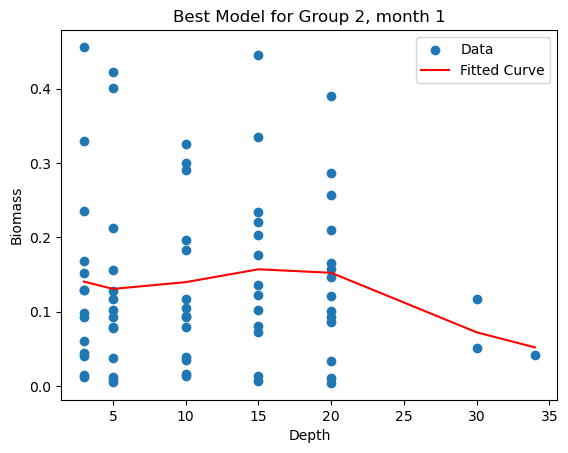

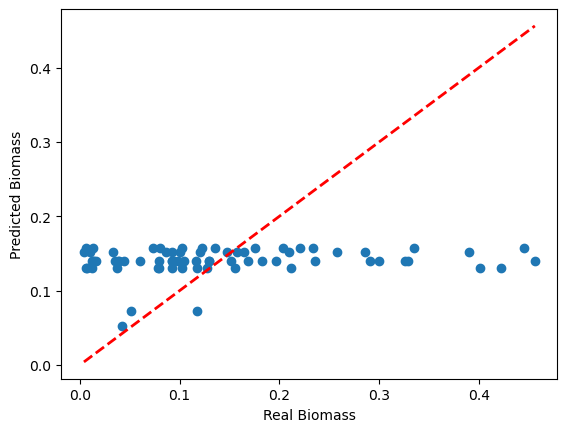

Group: 2
Month: 2
Best Model: quartic
Best Model Parameters: [-3.32586200e-06  1.99280501e-04 -3.50174494e-03  1.14734452e-02
  2.03228267e-01]

R-Squared: 0.21760276588439276


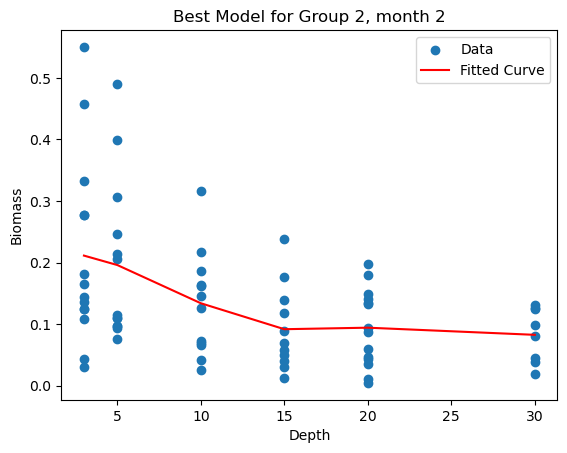

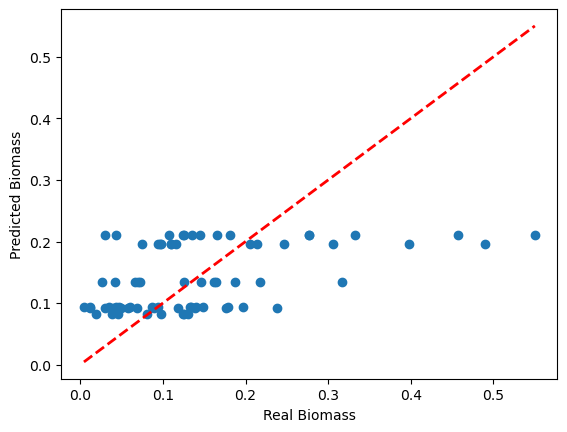

Group: 2
Month: 3
Best Model: quartic
Best Model Parameters: [-4.71183451e-06  2.00105116e-04 -1.10374478e-04 -7.19091781e-02
  7.04532941e-01]

R-Squared: 0.28251462240074077


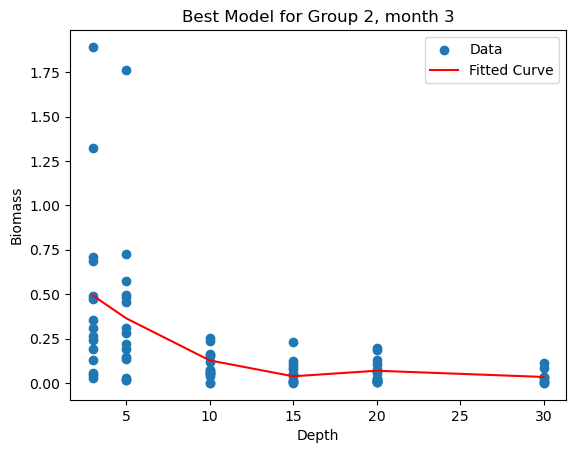

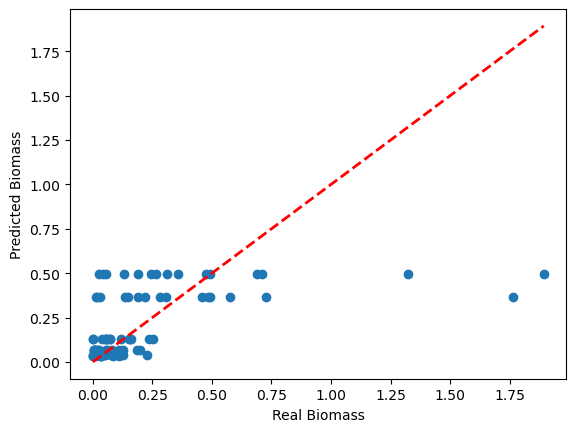

Group: 2
Month: 4
Best Model: quartic
Best Model Parameters: [-4.84227500e-06  3.27959121e-04 -7.00500792e-03  3.92534116e-02
  2.01752547e-01]

R-Squared: 0.3630574704895895


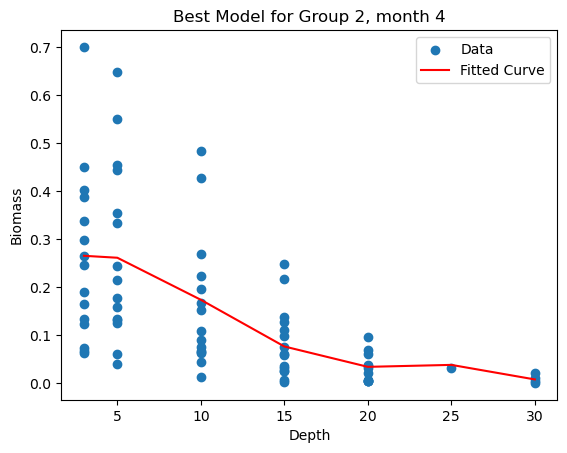

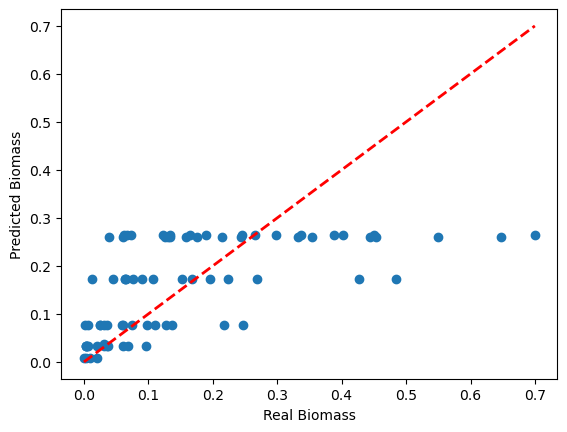

Group: 2
Month: 5
Best Model: quartic
Best Model Parameters: [-7.84531215e-07  5.85589343e-04 -2.04503581e-02  1.87961304e-01
 -2.31962305e-02]

R-Squared: 0.18429822311042


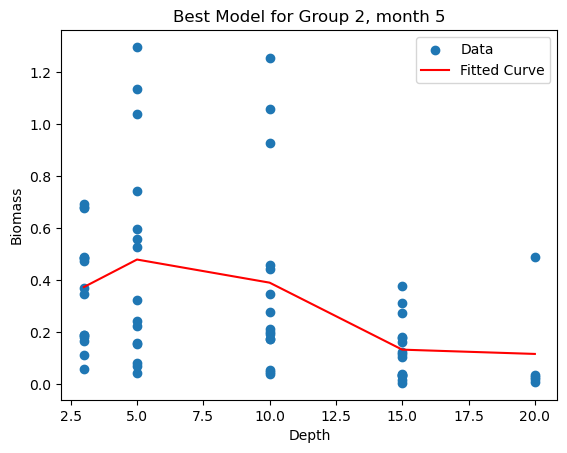

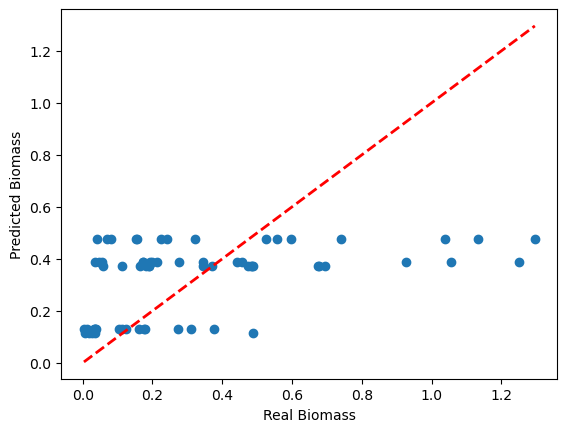

Group: 2
Month: 6
Best Model: quartic
Best Model Parameters: [ 9.50783667e-05 -3.86123344e-03  4.88069985e-02 -2.42046390e-01
  1.03255628e+00]

R-Squared: 0.27411907986547746


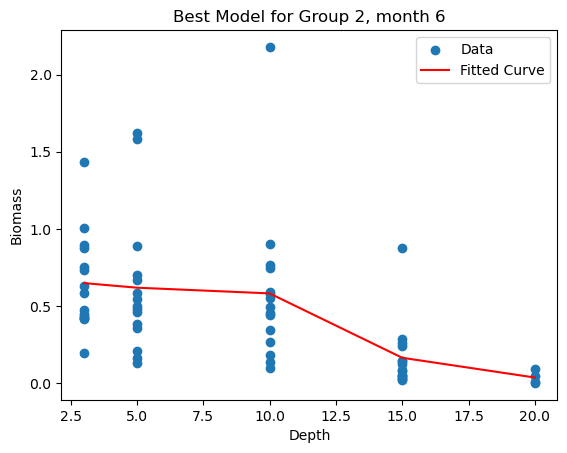

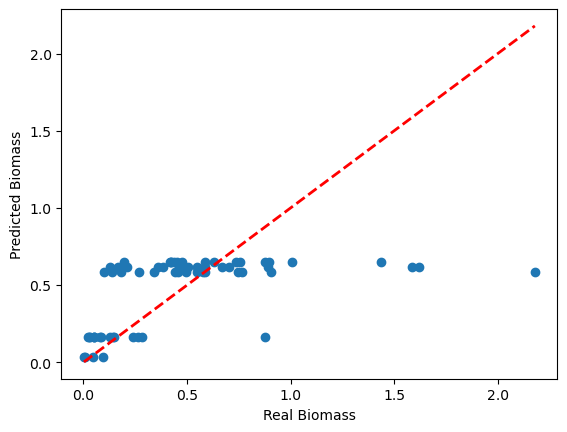

Group: 2
Month: 7
Best Model: quartic
Best Model Parameters: [ 2.42728148e-05 -1.24646147e-03  2.04623550e-02 -1.55041987e-01
  1.02346934e+00]

R-Squared: 0.37258734180609754


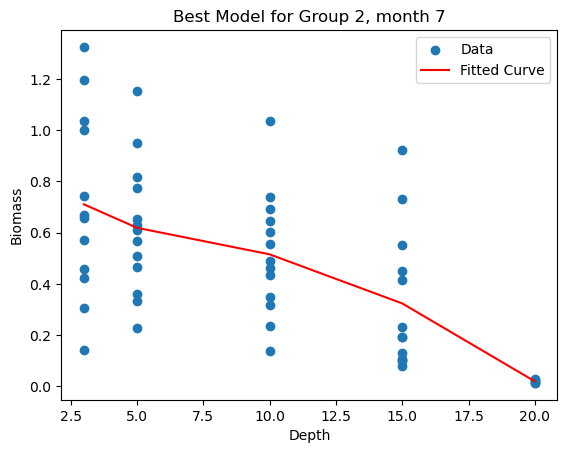

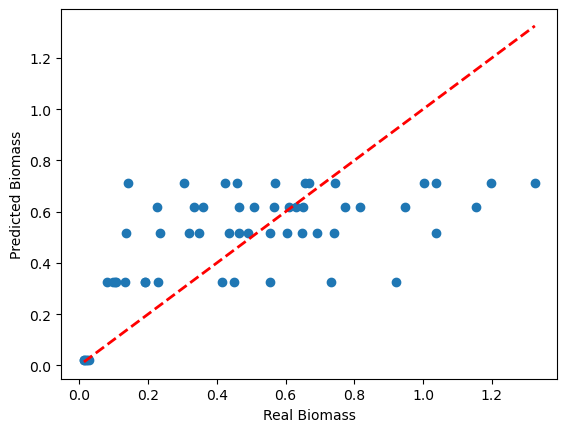

Group: 2
Month: 8
Best Model: quartic
Best Model Parameters: [ 1.03554542e-04 -4.44962869e-03  5.98078406e-02 -3.09357645e-01
  1.48955228e+00]

R-Squared: 0.13733697224499353


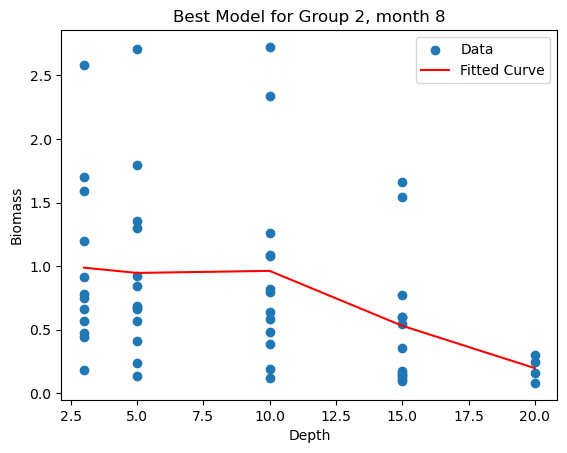

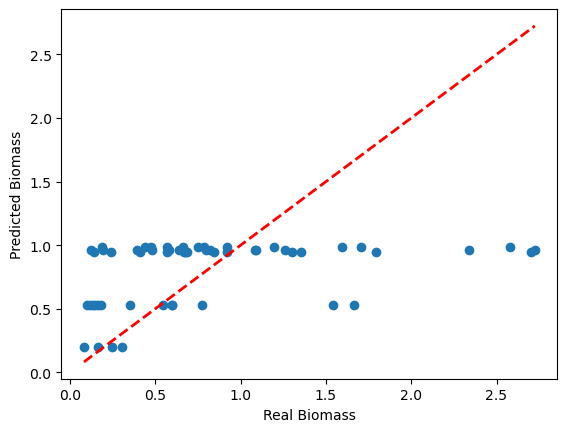

Group: 2
Month: 9
Best Model: quartic
Best Model Parameters: [ 1.72022998e-04 -7.15346506e-03  9.28492789e-02 -4.76523785e-01
  2.17394505e+00]

R-Squared: 0.32687575248027456


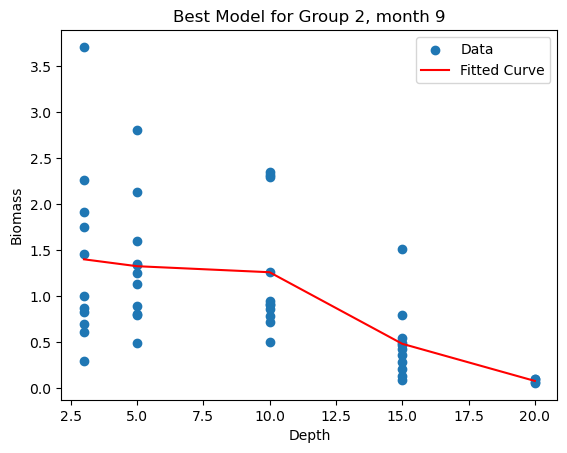

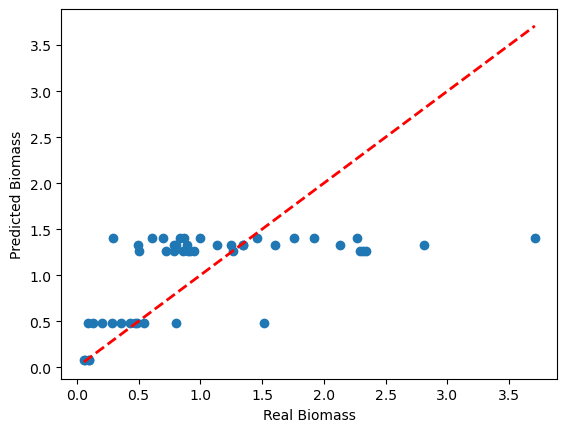

Group: 2
Month: 10
Best Model: quartic
Best Model Parameters: [-1.27649959e-04  5.59083374e-03 -8.76066306e-02  5.48292940e-01
 -2.07942706e-02]

R-Squared: 0.21405020507436778


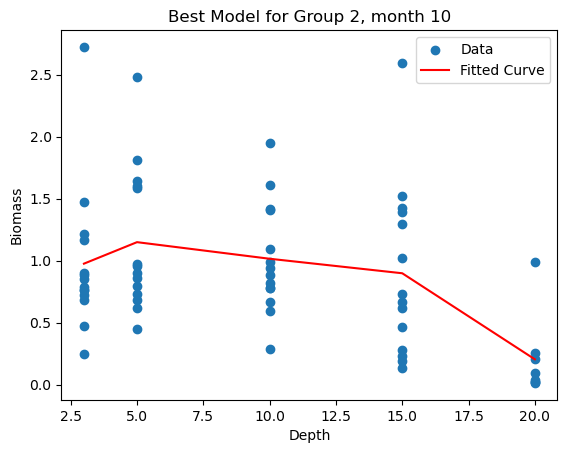

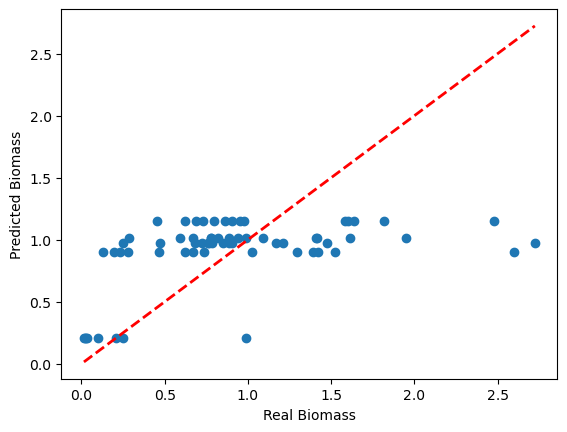

Group: 2
Month: 11
Best Model: quartic
Best Model Parameters: [ 7.36477571e-05 -3.32168792e-03  4.82549908e-02 -2.50750001e-01
  1.02591467e+00]

R-Squared: 0.0707659192543294


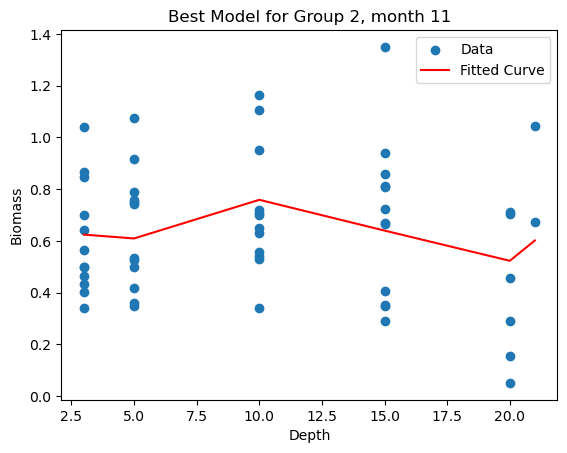

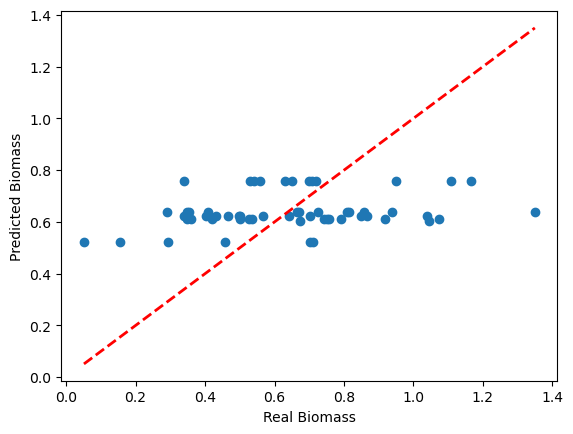

Group: 2
Month: 12
Best Model: quartic
Best Model Parameters: [-1.81542345e-06  3.28120894e-05  6.78895136e-04 -1.24223125e-02
  3.88488128e-01]

R-Squared: 0.05299408502646186


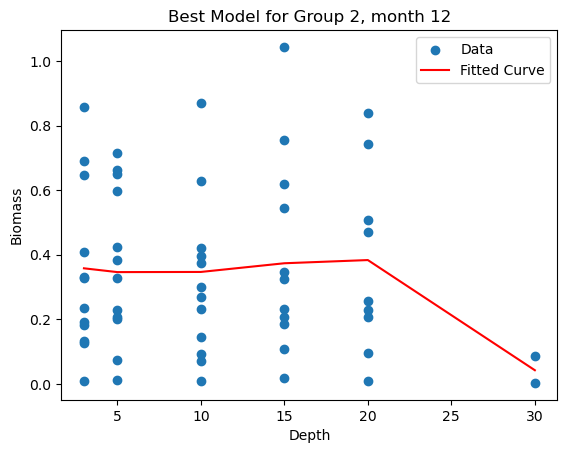

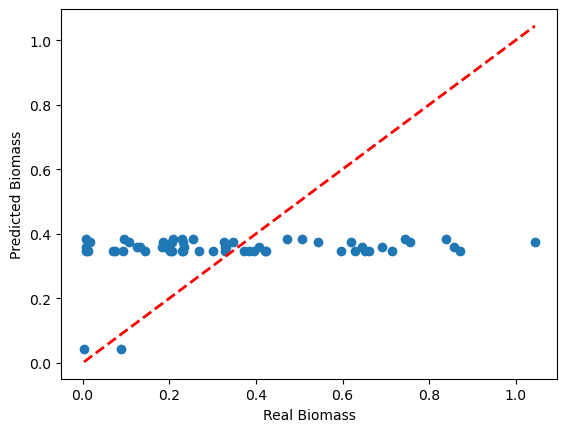

Group: 3
Month: 1
Best Model: quartic
Best Model Parameters: [ 5.97850697e-06 -3.95704053e-04  8.11165977e-03 -6.07104322e-02
  4.66341960e-01]

R-Squared: 0.012615583308005607


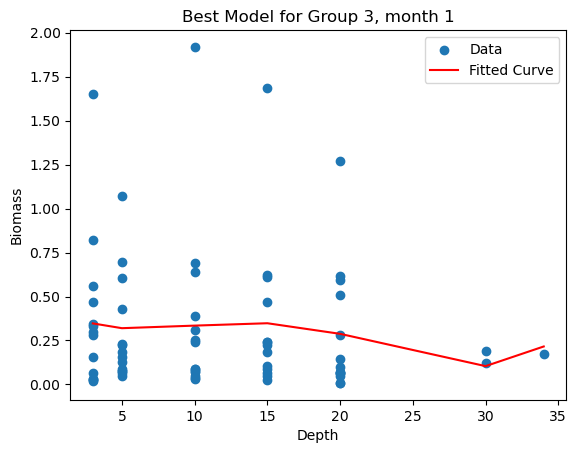

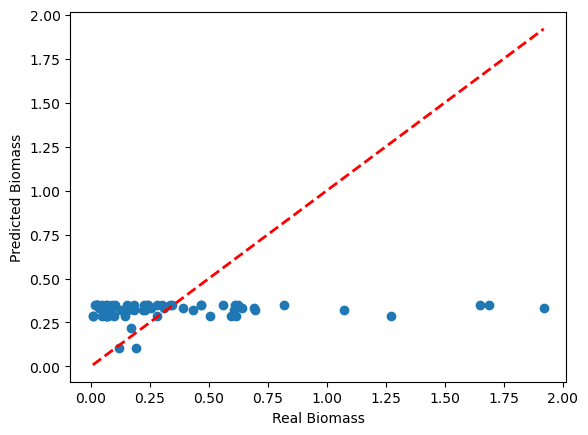

Group: 3
Month: 2
Best Model: quartic
Best Model Parameters: [ 1.23996112e-05 -8.12592296e-04  1.72801127e-02 -1.25920386e-01
  6.34137763e-01]

R-Squared: 0.011574504016252929


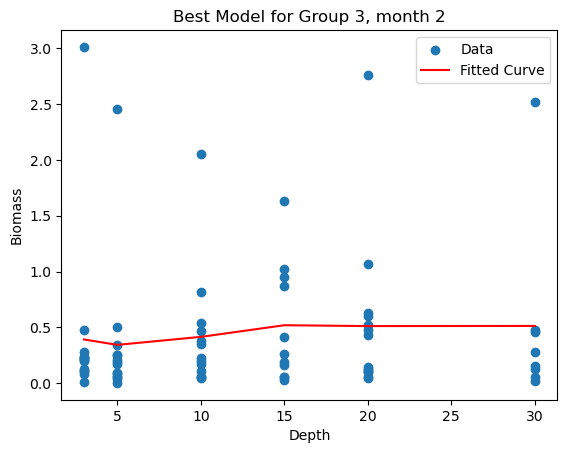

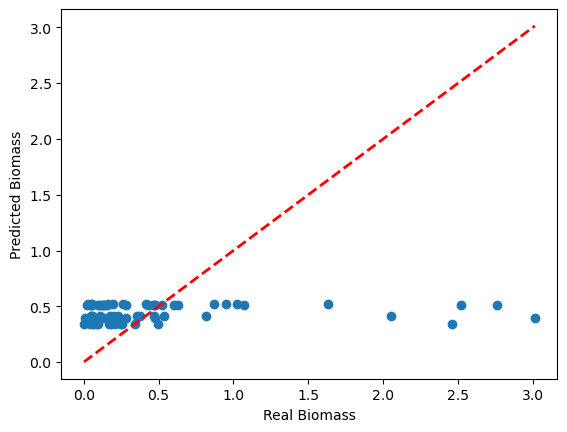

Group: 3
Month: 3
Best Model: quartic
Best Model Parameters: [-1.06510785e-05  7.06169813e-04 -1.49376395e-02  1.04777887e-01
  1.71213960e-01]

R-Squared: 0.026544634970513736


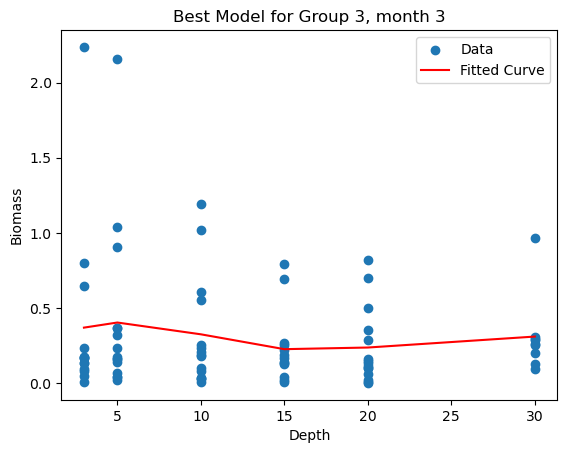

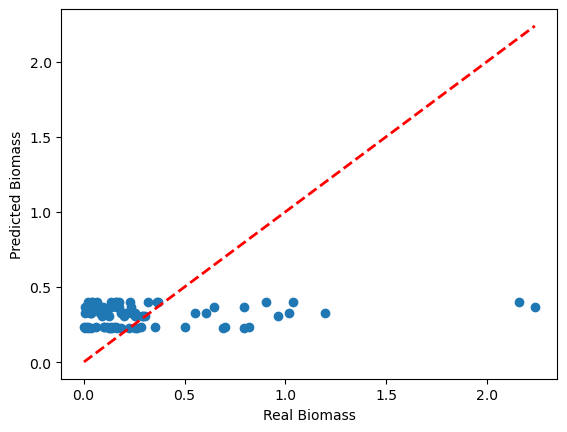

Group: 3
Month: 4
Best Model: quartic
Best Model Parameters: [-3.32031239e-06  2.31558388e-04 -5.26997244e-03  3.83508516e-02
  9.22165204e-02]

R-Squared: 0.10549450818702888


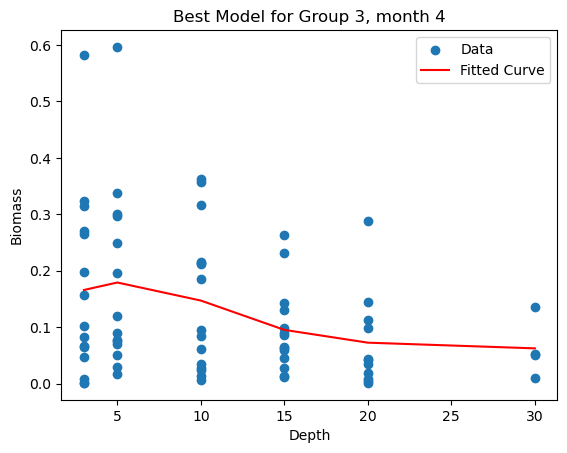

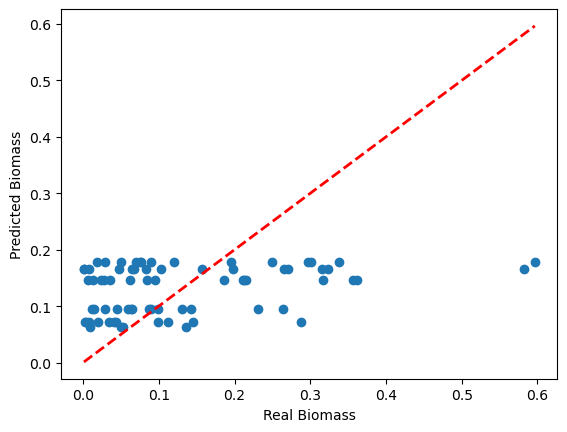

Group: 3
Month: 5
Best Model: quartic
Best Model Parameters: [ 2.19593372e-05 -9.34466380e-04  1.28214866e-02 -6.75706421e-02
  2.10634793e-01]

R-Squared: 0.1581693843142994


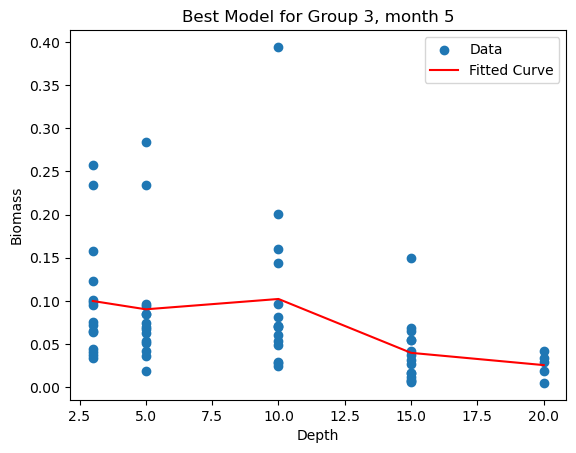

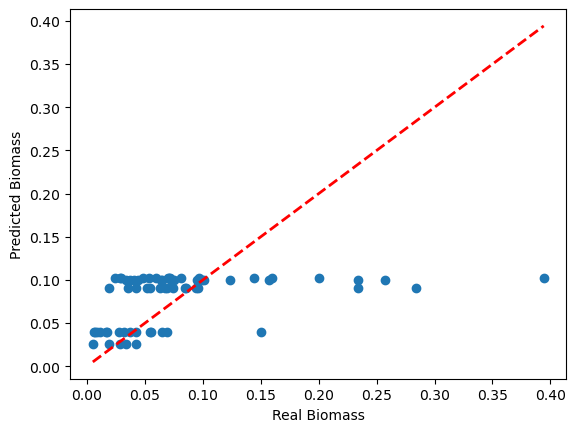

Group: 3
Month: 6
Best Model: quartic
Best Model Parameters: [ 2.88918745e-05 -1.21449022e-03  1.58948832e-02 -8.12852875e-02
  3.91946405e-01]

R-Squared: 0.18540963858708637


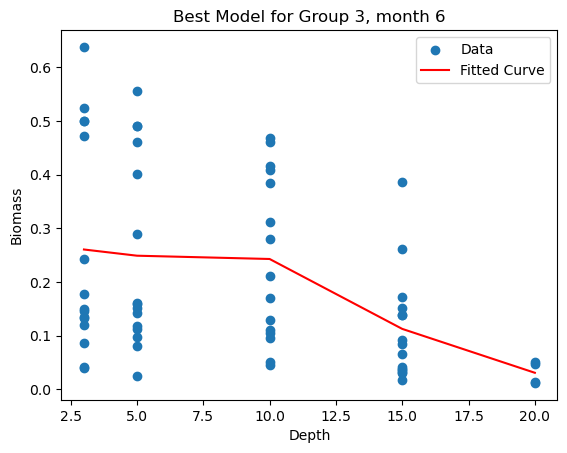

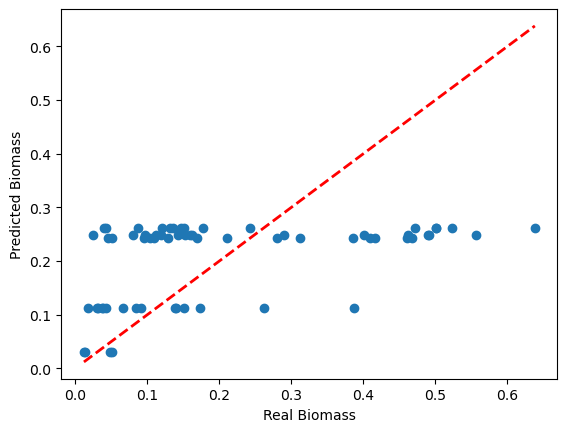

Group: 3
Month: 7
Best Model: quartic
Best Model Parameters: [ 4.50088464e-06 -2.77185149e-04  4.39465862e-03 -2.98167051e-02
  3.74497774e-01]

R-Squared: 0.31022002022093575


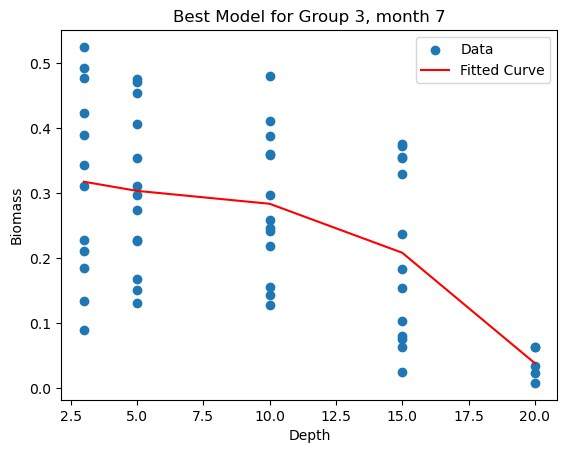

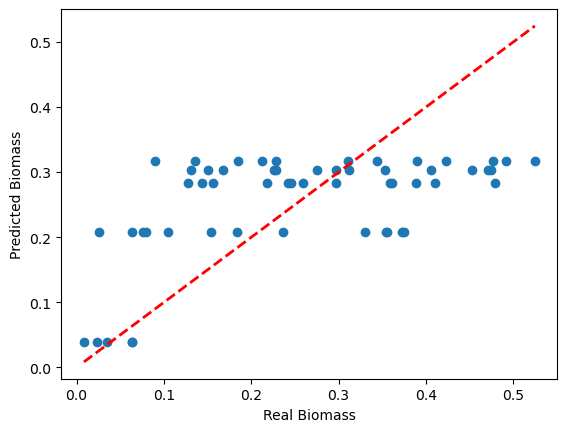

Group: 3
Month: 8
Best Model: quartic
Best Model Parameters: [-8.11418270e-06  4.49748697e-04 -8.52961438e-03  5.47125563e-02
  1.84839434e-01]

R-Squared: 0.06887500329766394


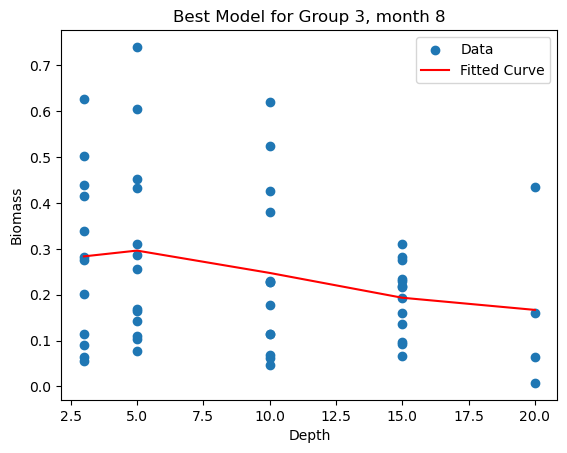

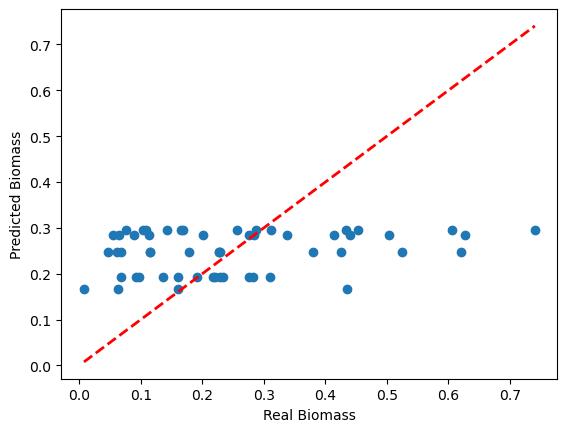

Group: 3
Month: 9
Best Model: quartic
Best Model Parameters: [-6.57699986e-05  2.98015879e-03 -4.94336306e-02  3.26338543e-01
  9.68383573e-02]

R-Squared: 0.05618115375631738


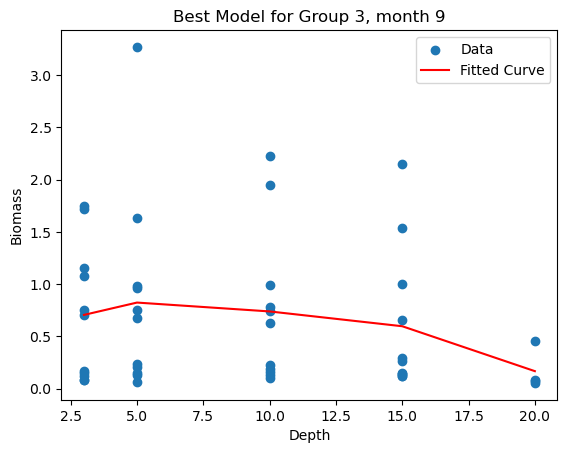

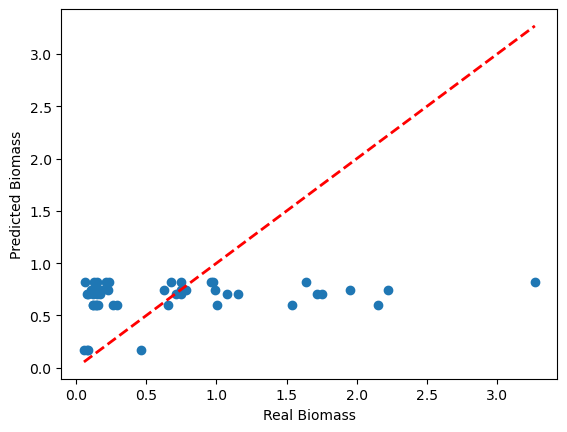

Group: 3
Month: 10
Best Model: quartic
Best Model Parameters: [-3.40964207e-05  1.17854045e-03 -1.53393261e-02  8.72574604e-02
  4.96338736e-01]

R-Squared: 0.19933522109199553


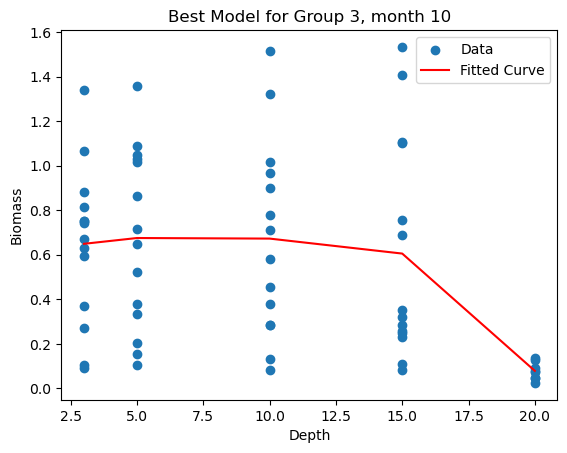

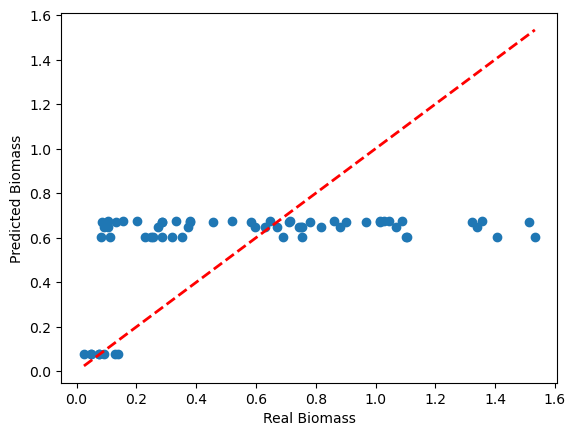

Group: 3
Month: 11
Best Model: quartic
Best Model Parameters: [ 4.98919061e-06 -2.11713246e-04  1.71952939e-03  8.77649579e-03
  3.42631779e-01]

R-Squared: 0.03524760179033759


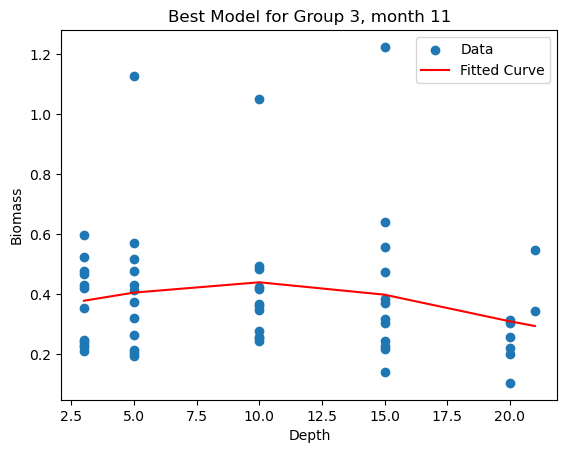

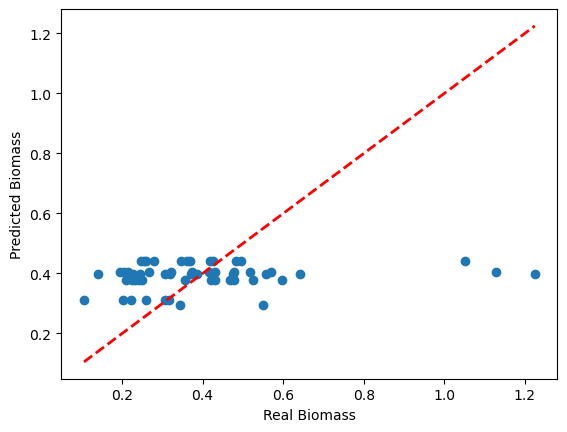

Group: 3
Month: 12
Best Model: quartic
Best Model Parameters: [ 7.51029384e-07 -5.59287956e-05  1.02039995e-03 -4.73589340e-03
  1.46873845e-01]

R-Squared: 0.09407414887770693


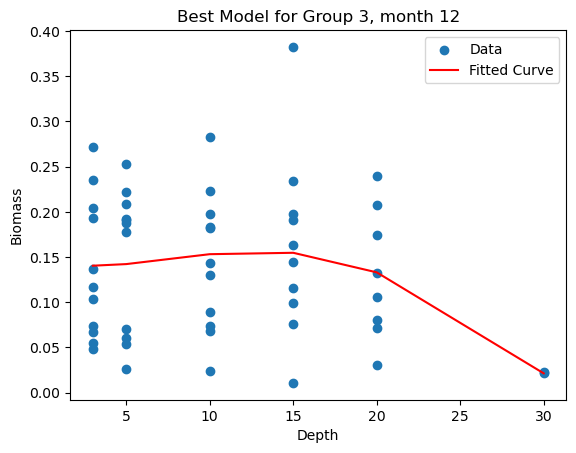

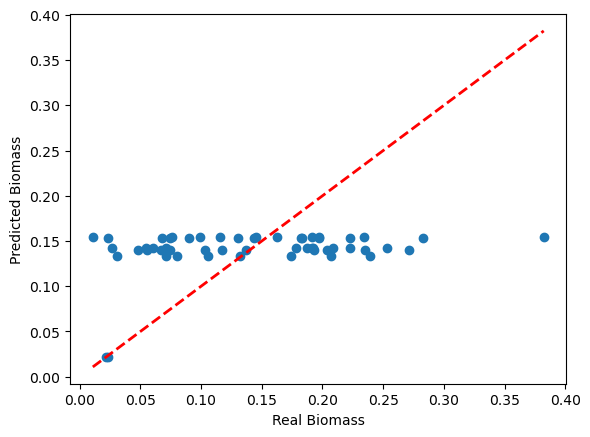

Group: 4
Month: 1
Best Model: quartic
Best Model Parameters: [ 1.80656907e-06 -1.20093242e-04  2.49593973e-03 -1.99185425e-02
  3.35603891e-01]

R-Squared: 0.016730766681650633


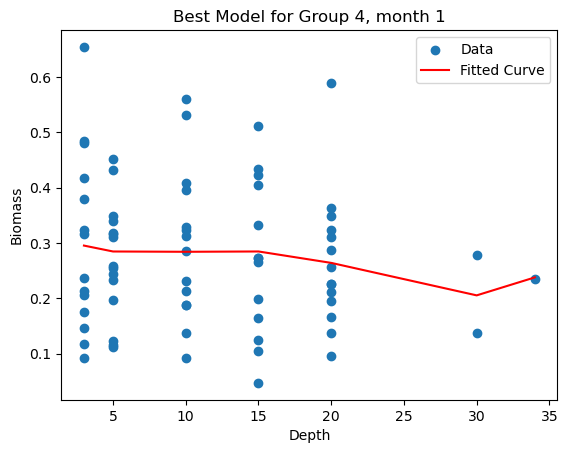

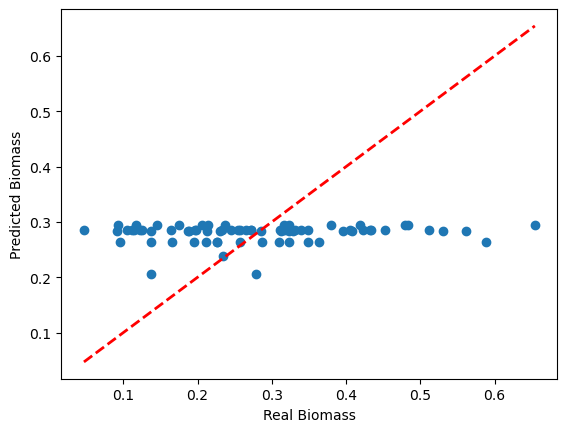

Group: 4
Month: 2
Best Model: quartic
Best Model Parameters: [-9.38233643e-06  6.17373870e-04 -1.34869720e-02  1.03166481e-01
  2.11735171e-01]

R-Squared: 0.1425654159805776


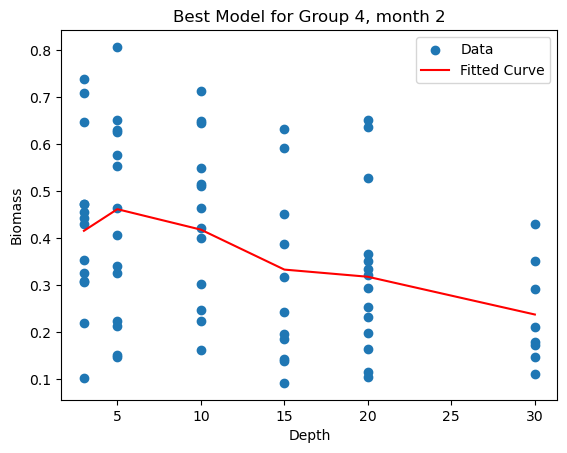

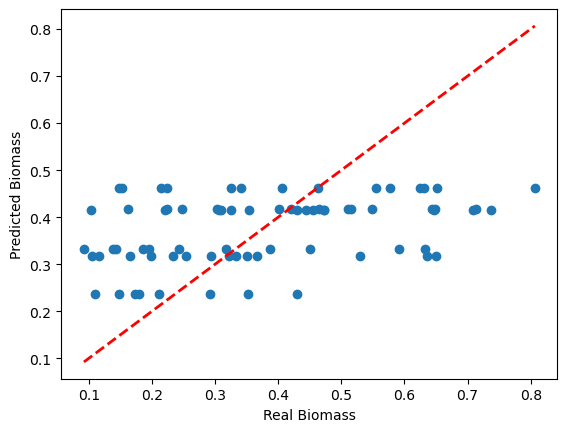

Group: 4
Month: 3
Best Model: quartic
Best Model Parameters: [-1.90586583e-05  1.22837102e-03 -2.55139690e-02  1.75606594e-01
  1.73261284e-01]

R-Squared: 0.2202508057415089


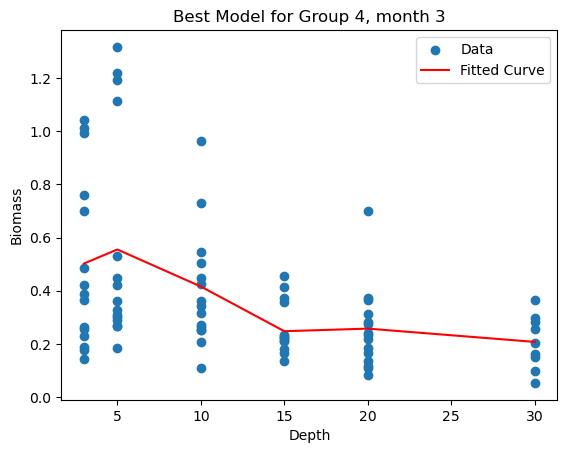

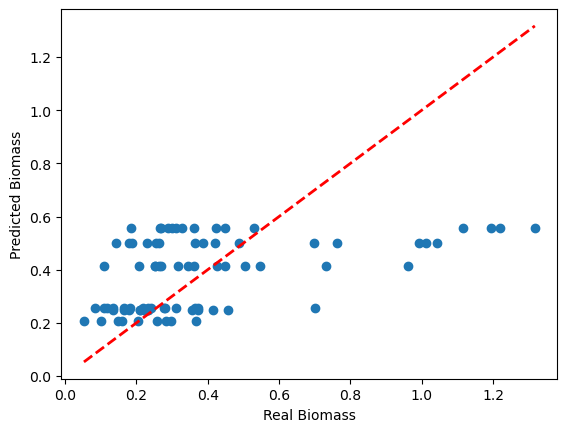

Group: 4
Month: 4
Best Model: quartic
Best Model Parameters: [-8.42893282e-06  6.55716595e-04 -1.67811036e-02  1.22242564e-01
  6.57703779e-01]

R-Squared: 0.2368816323633084


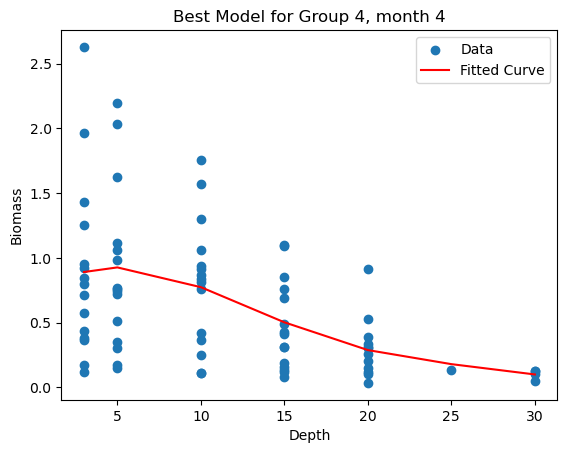

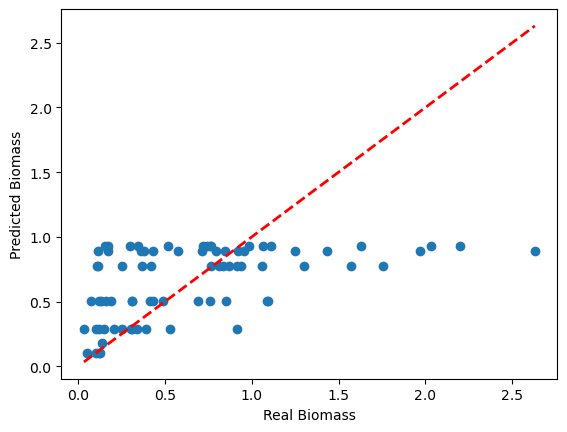

Group: 4
Month: 5
Best Model: quartic
Best Model Parameters: [ 2.06348202e-04 -8.58329478e-03  1.15105222e-01 -6.21383152e-01
  2.41444181e+00]

R-Squared: 0.17804082642080366


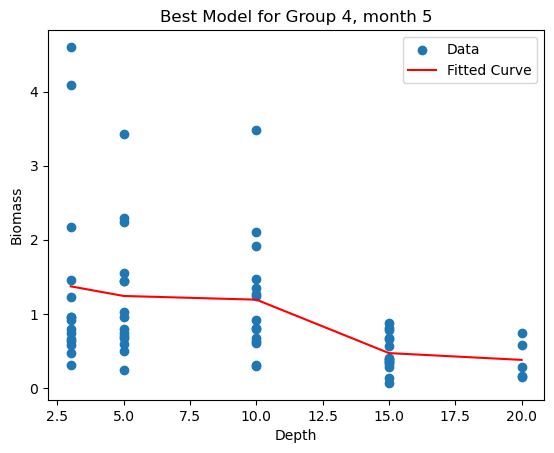

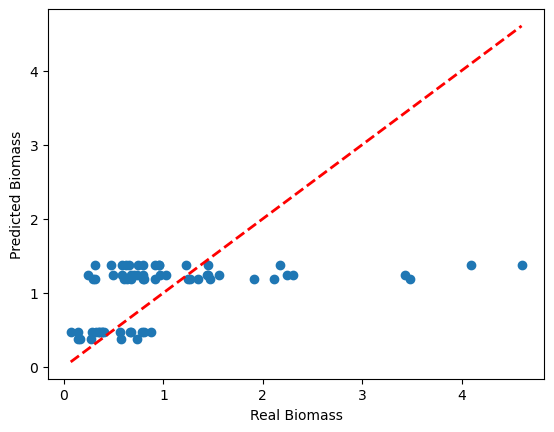

Group: 4
Month: 6
Best Model: quartic
Best Model Parameters: [ 8.22128622e-05 -3.86745427e-03  6.08961402e-02 -4.35646958e-01
  2.38970849e+00]

R-Squared: 0.17813210305577742


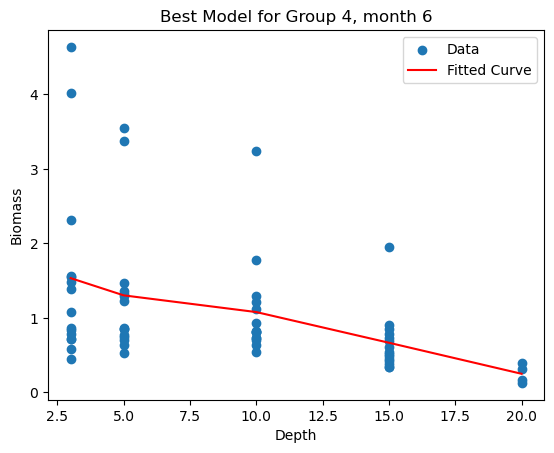

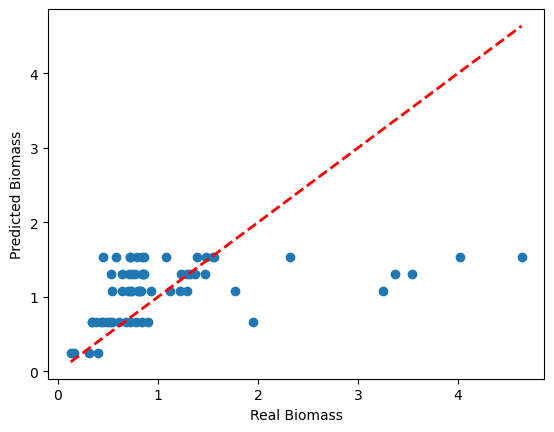

Group: 4
Month: 7
Best Model: quartic
Best Model Parameters: [-4.06716427e-06  2.36512933e-04 -8.68255273e-03  7.88781077e-02
  8.52063915e-01]

R-Squared: 0.15651212184344265


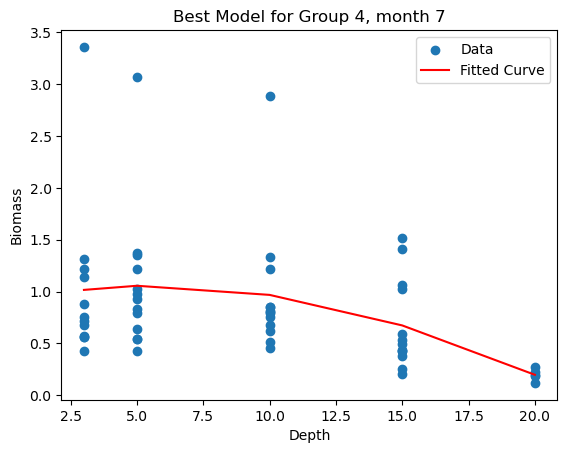

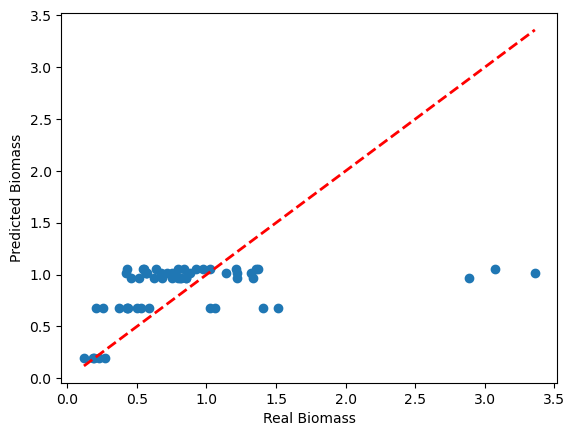

Group: 4
Month: 8
Best Model: quartic
Best Model Parameters: [ 3.50936493e-05 -1.58506797e-03  2.15556841e-02 -1.10073813e-01
  1.12554400e+00]

R-Squared: 0.0866332792957818


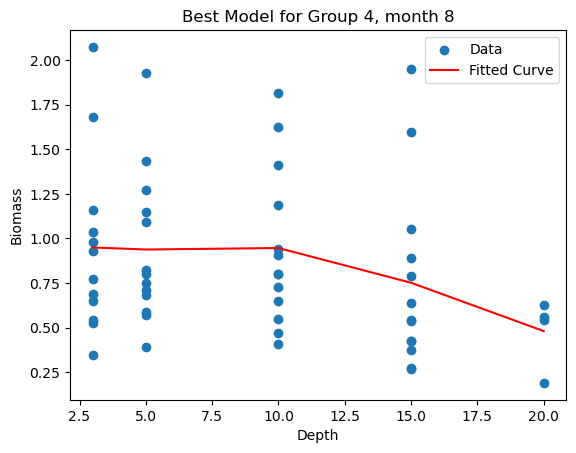

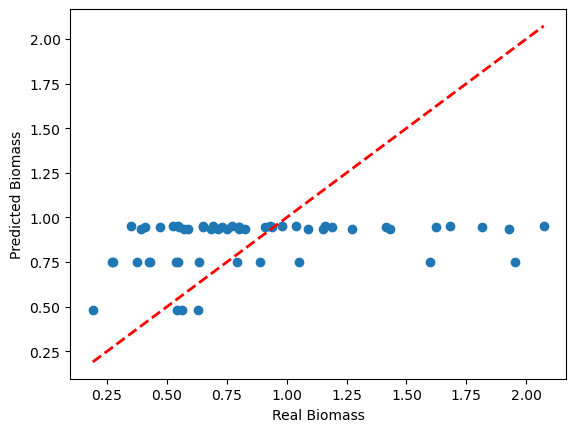

Group: 4
Month: 9
Best Model: quartic
Best Model Parameters: [ 4.29513481e-05 -1.81722257e-03  2.33279297e-02 -1.29956117e-01
  1.36595741e+00]

R-Squared: 0.10687032280785558


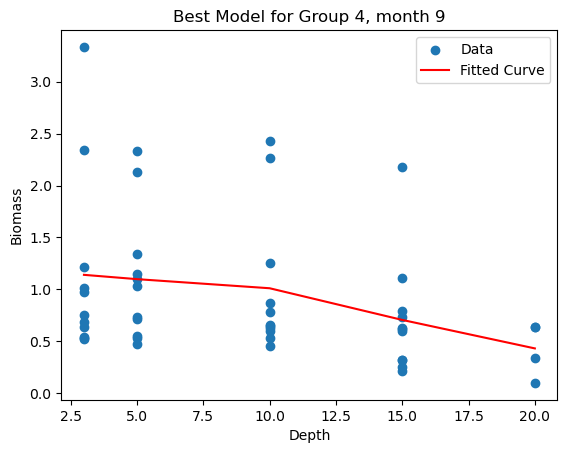

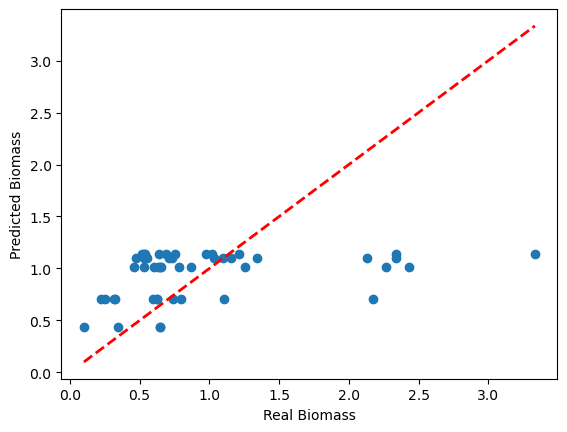

Group: 4
Month: 10
Best Model: quartic
Best Model Parameters: [-1.84339460e-04  8.49848834e-03 -1.39145090e-01  9.01523133e-01
 -1.45584590e-01]

R-Squared: 0.06430991102694905


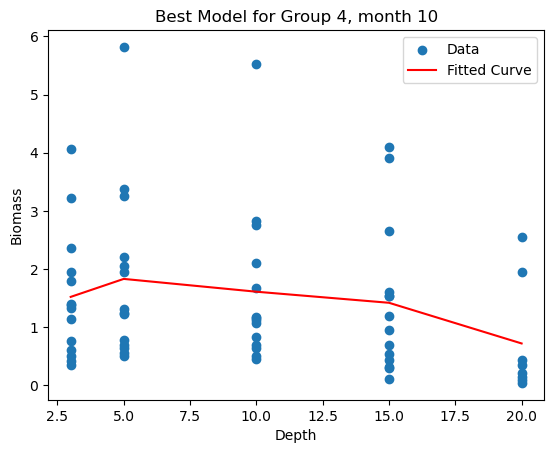

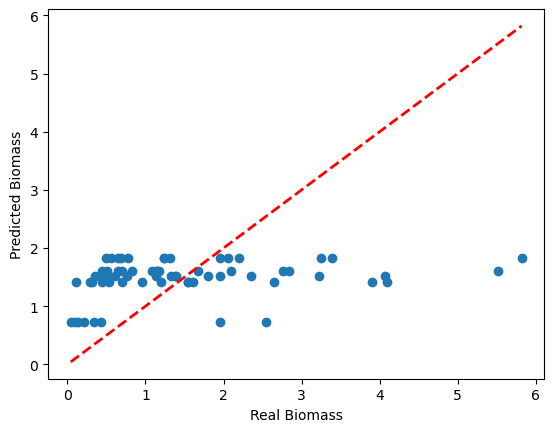

Group: 4
Month: 11
Best Model: quartic
Best Model Parameters: [-2.55244182e-05  1.48645653e-03 -2.55951622e-02  1.40729808e-01
  1.64806956e+00]

R-Squared: 0.006515759572509383


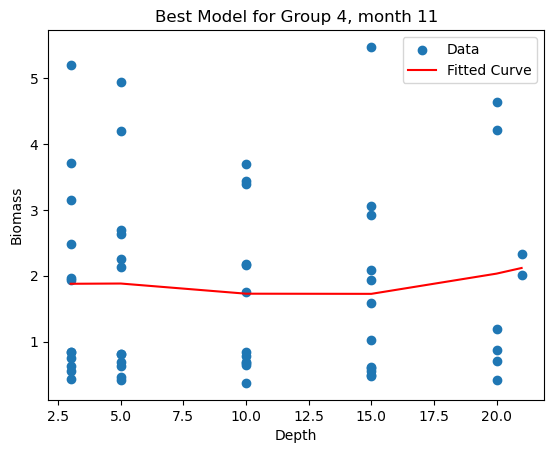

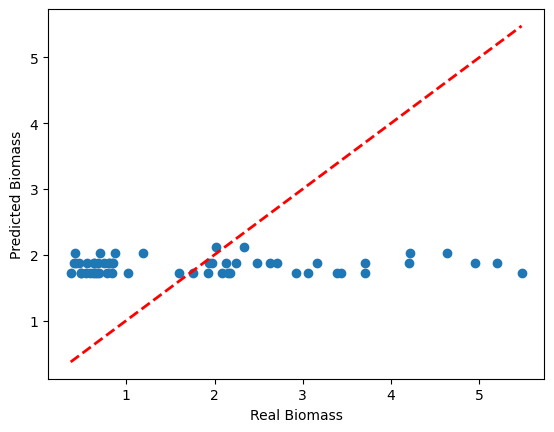

Group: 4
Month: 12
Best Model: quartic
Best Model Parameters: [-1.39565978e-05  6.38703317e-04 -1.09123908e-02  1.00247847e-01
  9.42966147e-01]

R-Squared: 0.03281825780577019


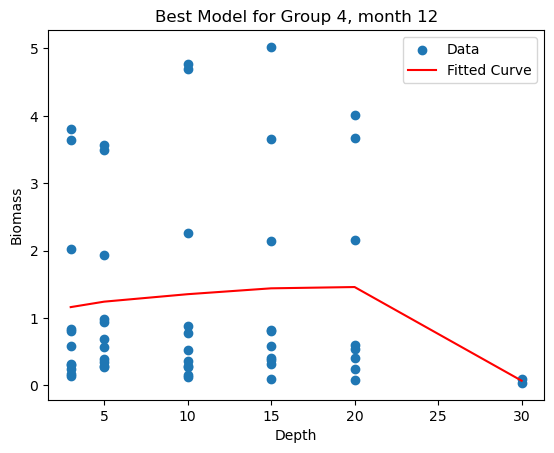

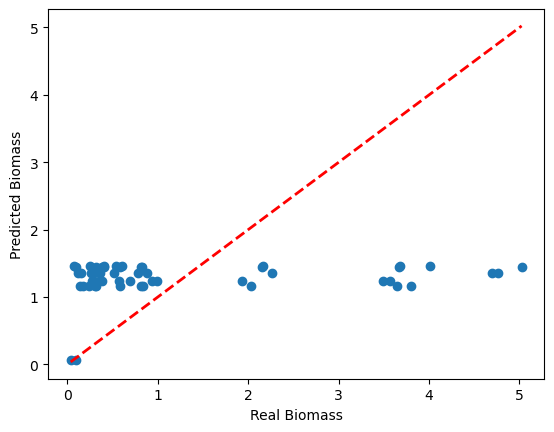

Group: 5
Month: 1
Best Model: logarithmic
Best Model Parameters: [-0.09497415  0.4816509 ]

R-Squared: 0.012023896193961603


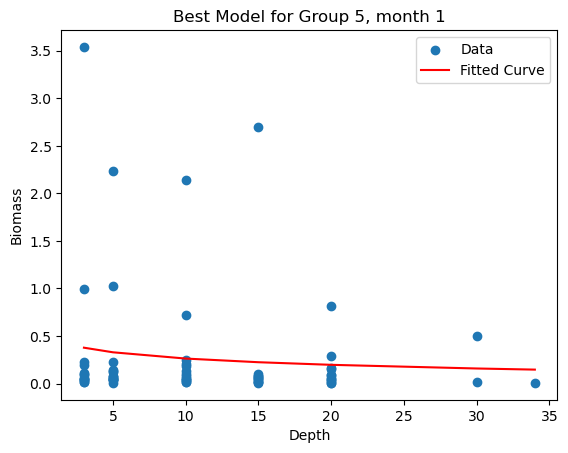

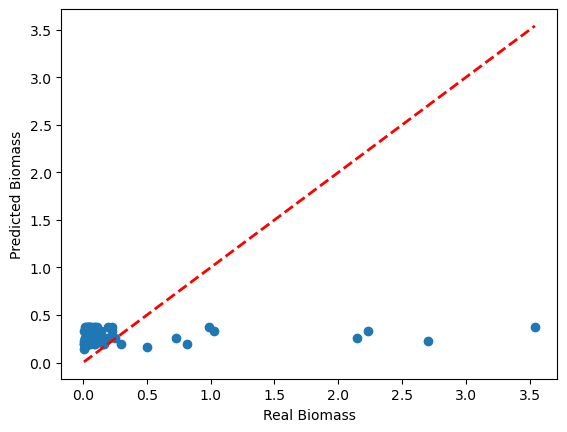

Group: 5
Month: 2
Best Model: quartic
Best Model Parameters: [ 1.72364058e-05 -7.08468478e-04  2.63674498e-03  7.80766710e-02
  6.20456705e-01]

R-Squared: 0.0387324162653685


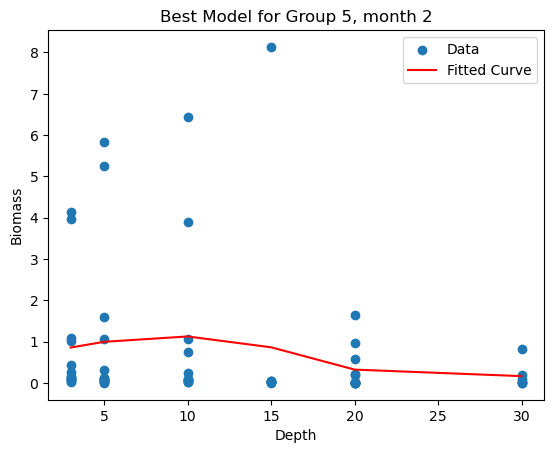

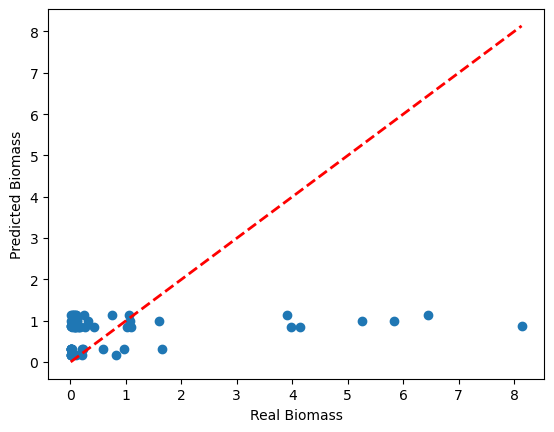

Group: 5
Month: 3
Best Model: power_law
Best Model Parameters: [16.63412696 -1.32152261]

R-Squared: 0.10941268516193403


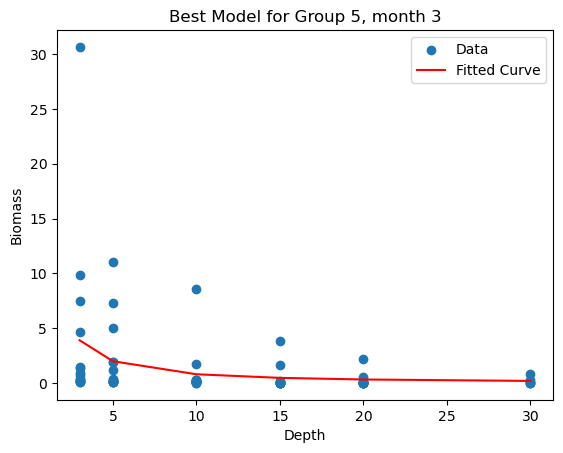

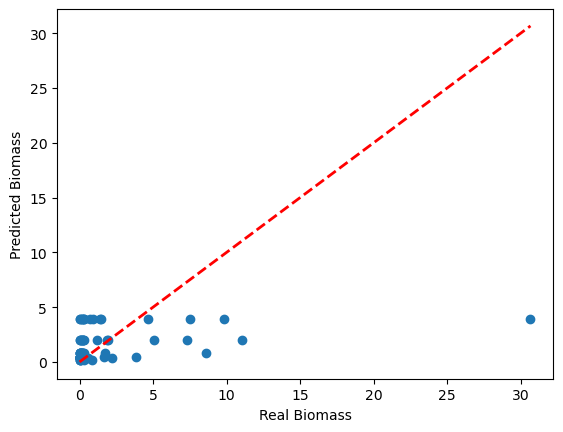

Group: 5
Month: 4
Best Model: quartic
Best Model Parameters: [ 1.66860093e-04 -8.88692007e-03  1.67660438e-01 -1.45073476e+00
  6.62322092e+00]

R-Squared: 0.20842319784745145


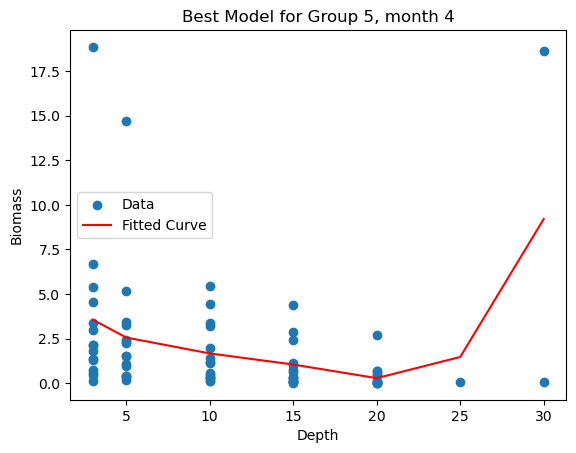

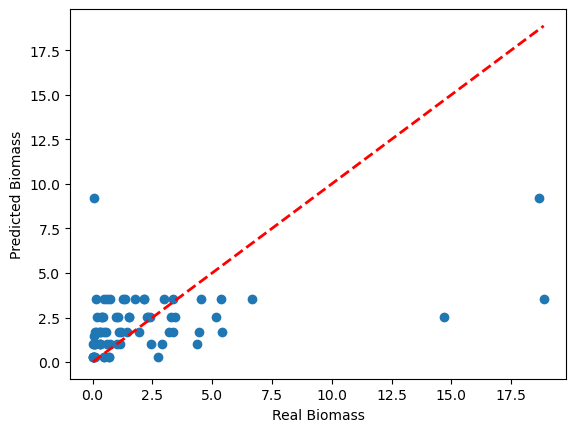

Group: 5
Month: 5
Best Model: quartic
Best Model Parameters: [ 5.34074285e-04 -2.22035489e-02  3.02591414e-01 -1.74242735e+00
  6.73187366e+00]

R-Squared: 0.25035722494500356


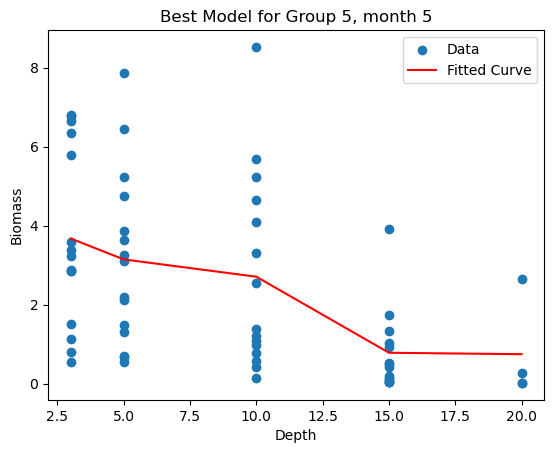

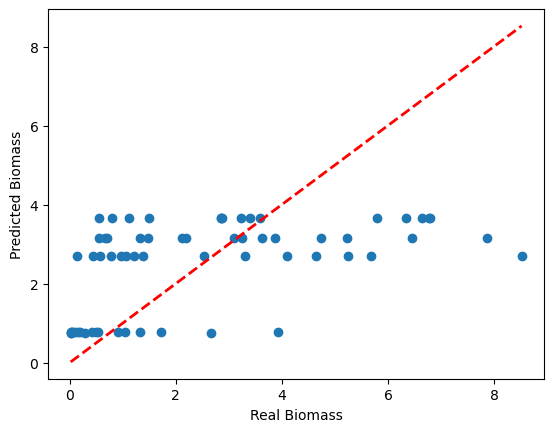

Group: 5
Month: 6
Best Model: quartic
Best Model Parameters: [ 2.32423684e-04 -9.88637184e-03  1.35820639e-01 -7.41879380e-01
  2.58731892e+00]

R-Squared: 0.12196441102144229


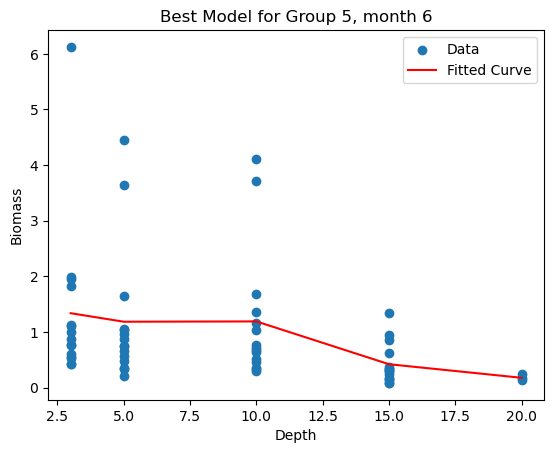

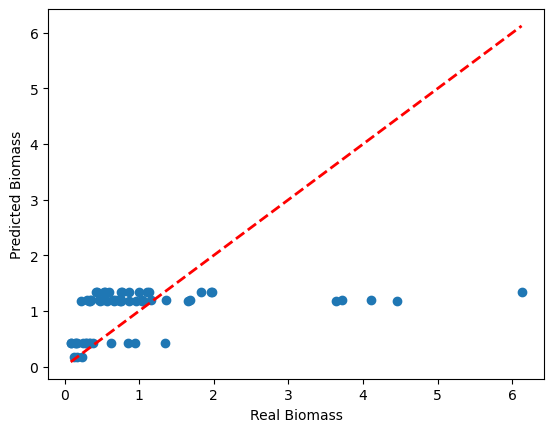

Group: 5
Month: 7
Best Model: cubic
Best Model Parameters: [-3.41885613e-04  7.92288153e-03 -5.44699905e-02  4.18039585e-01]

R-Squared: 0.03313627289347654


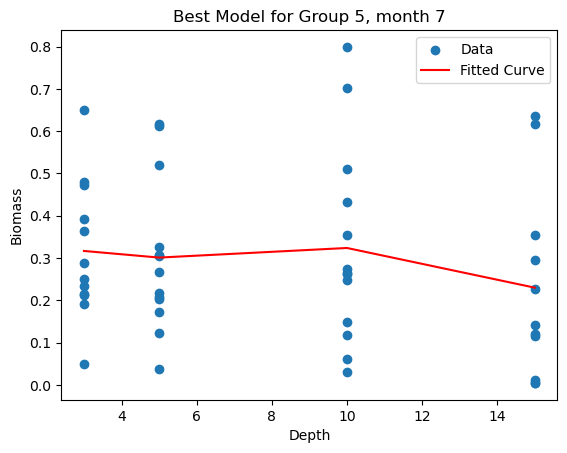

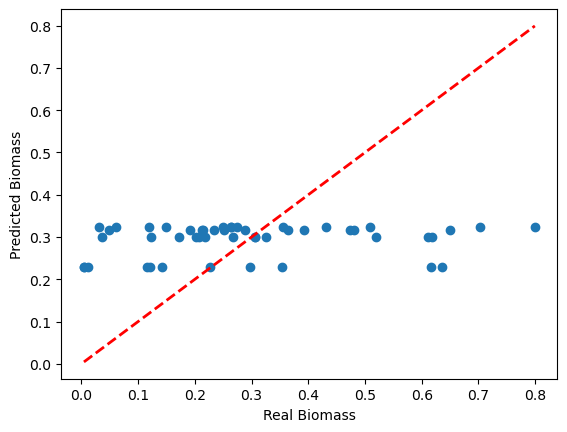

Group: 5
Month: 8
Best Model: quartic
Best Model Parameters: [ 2.29818190e-07 -4.96082139e-05  8.89532704e-05  1.71807112e-02
  5.53125351e-02]

R-Squared: 0.08370621423392222


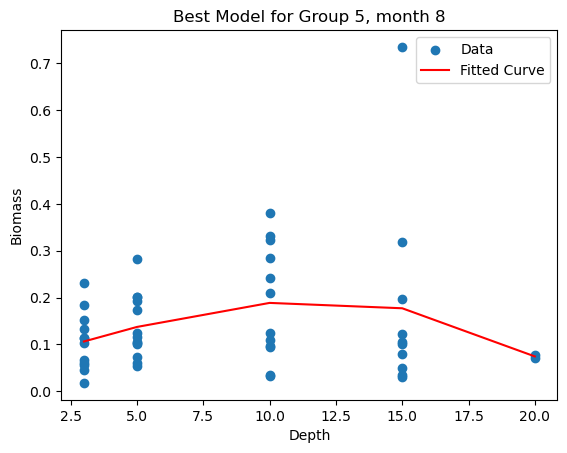

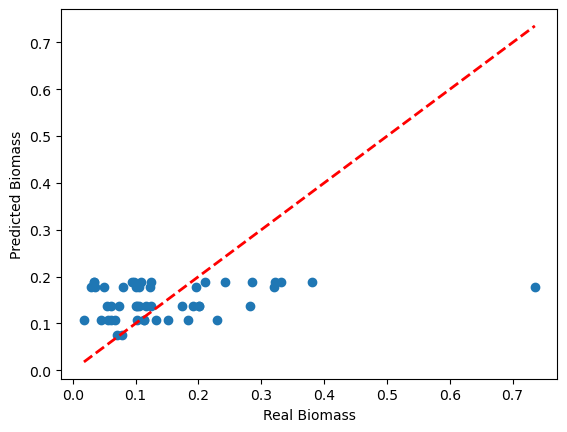

Group: 5
Month: 9
Best Model: quartic
Best Model Parameters: [ 9.94288765e-07  1.15218113e-04 -5.14036081e-03  5.34115847e-02
 -1.20781802e-02]

R-Squared: 0.12223549134437828


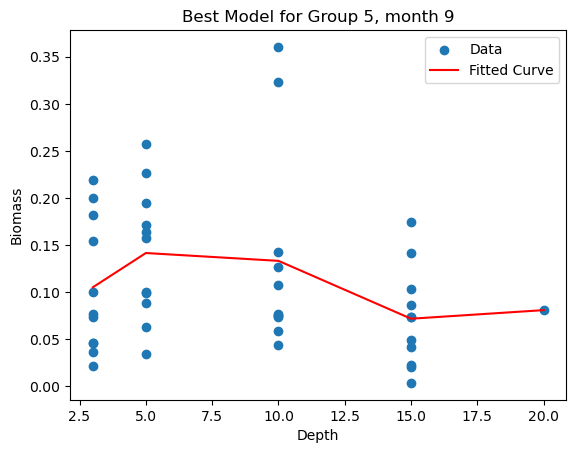

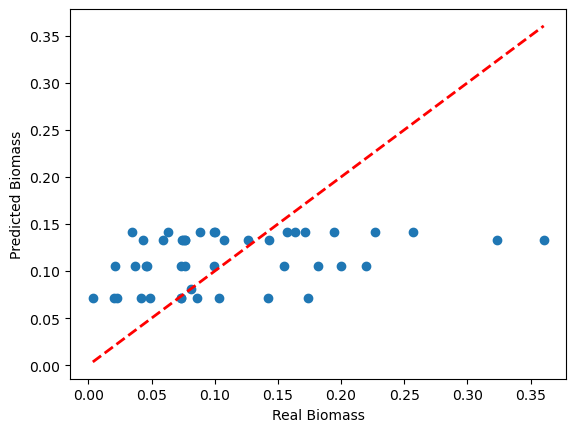

Group: 5
Month: 10
Best Model: quartic
Best Model Parameters: [-5.26674426e-06  1.97854922e-04 -2.19865302e-03  3.81198055e-03
  9.77089574e-02]

R-Squared: 0.05125996268660549


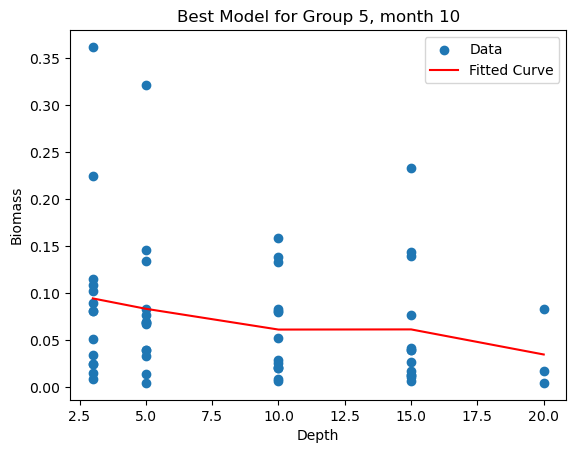

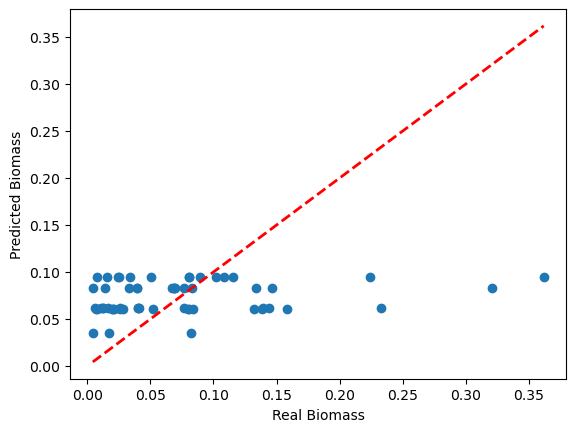

Group: 5
Month: 11
Best Model: quartic
Best Model Parameters: [ 8.02598571e-06 -4.56007347e-04  8.05291349e-03 -5.27318691e-02
  2.32191505e-01]

R-Squared: 0.03536656312260544


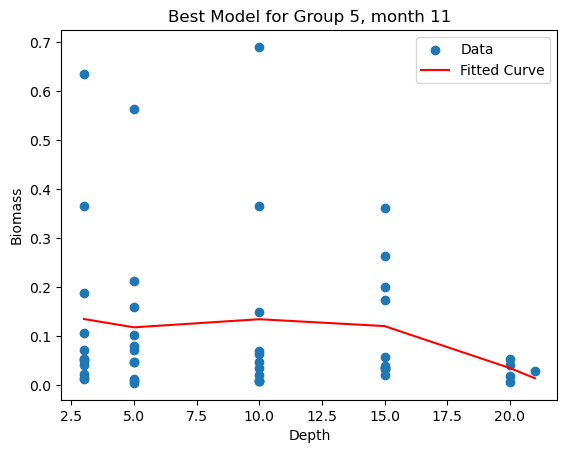

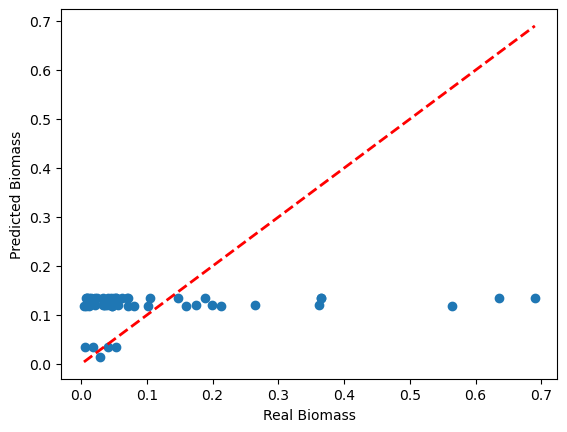

Group: 5
Month: 12
Best Model: quartic
Best Model Parameters: [-1.66063800e-05  5.86346235e-04 -5.34719157e-03 -1.46984015e-02
  4.84067973e-01]

R-Squared: 0.035870215140682005


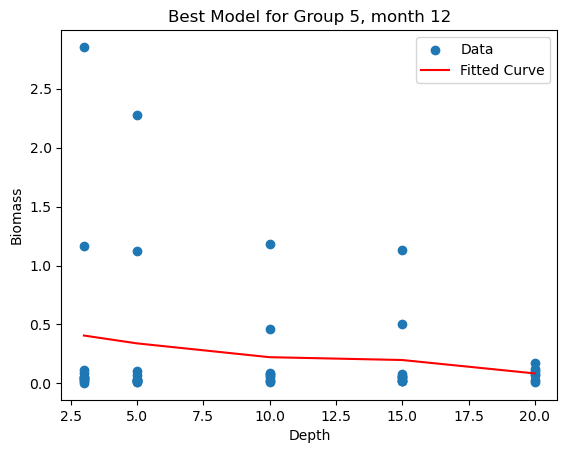

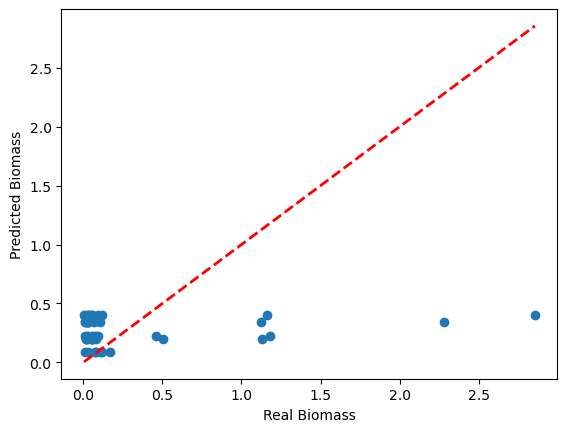

Group: 6
Month: 1
Best Model: quartic
Best Model Parameters: [-1.09868950e-07 -1.99010934e-05  8.85932526e-04 -1.32214679e-02
  3.89317357e-01]

R-Squared: 0.09657577459182343


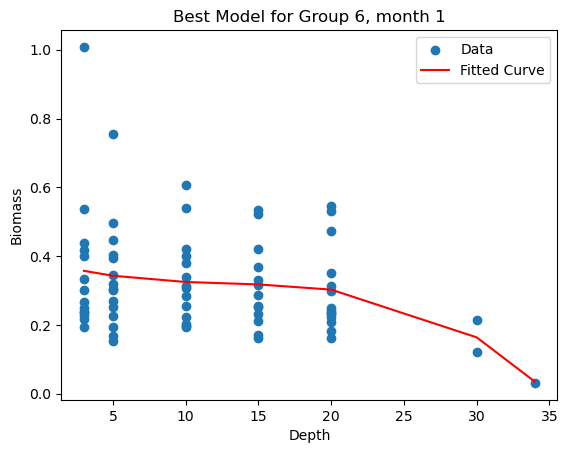

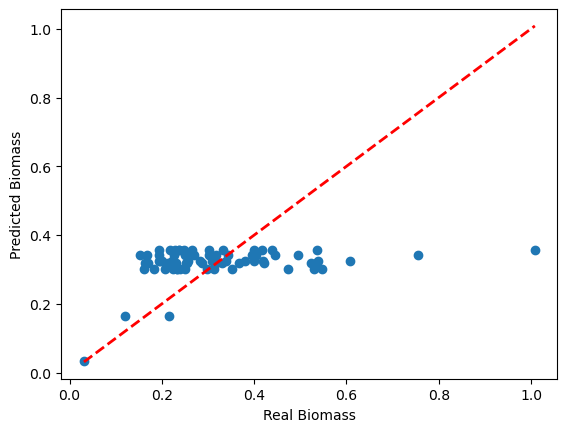

Group: 6
Month: 2
Best Model: quartic
Best Model Parameters: [-7.96416795e-06  5.26301778e-04 -1.03779687e-02  3.59388860e-02
  6.56011244e-01]

R-Squared: 0.252879400913093


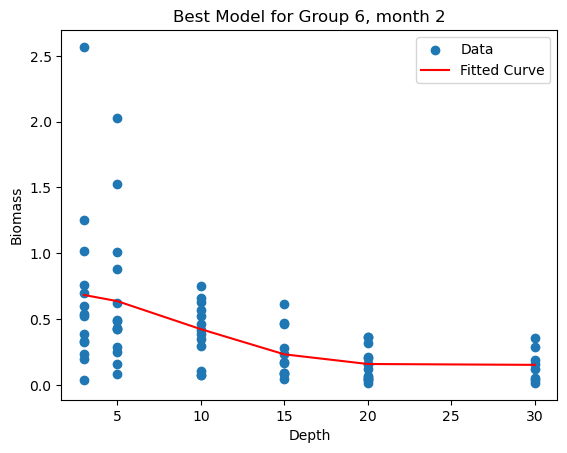

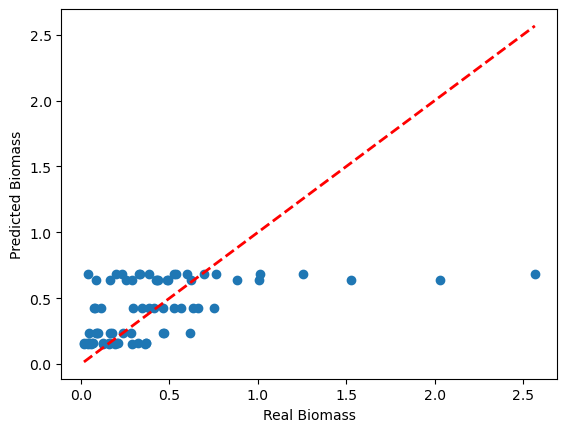

Group: 6
Month: 3
Best Model: quartic
Best Model Parameters: [ 6.45598545e-06 -4.11227519e-04  9.01145772e-03 -9.24241621e-02
  5.90508487e-01]

R-Squared: 0.34578084437792667


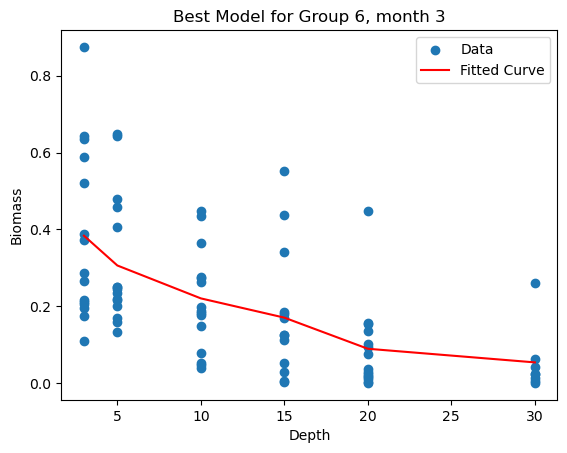

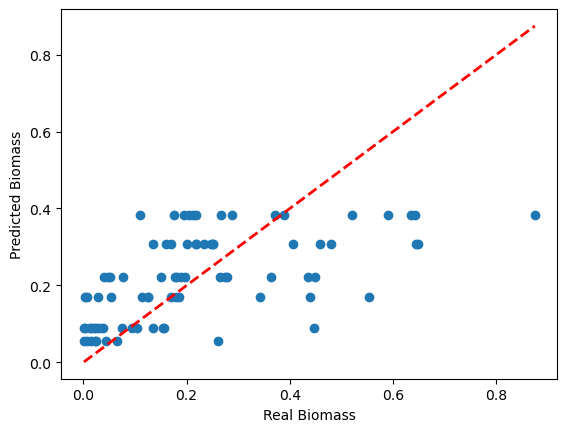

Group: 6
Month: 4
Best Model: quartic
Best Model Parameters: [-1.38854181e-06  6.52413316e-05 -4.30561605e-04 -1.72875316e-02
  3.05926204e-01]

R-Squared: 0.1927064008930267


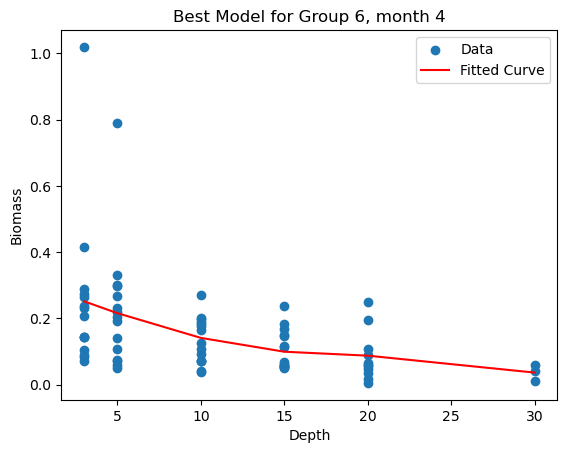

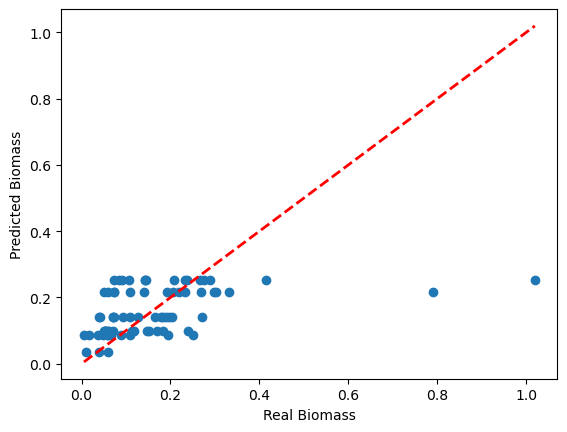

Group: 6
Month: 5
Best Model: quartic
Best Model Parameters: [ 2.92770198e-05 -1.26713166e-03  1.75487993e-02 -9.39998220e-02
  3.79237614e-01]

R-Squared: 0.3523356738500437


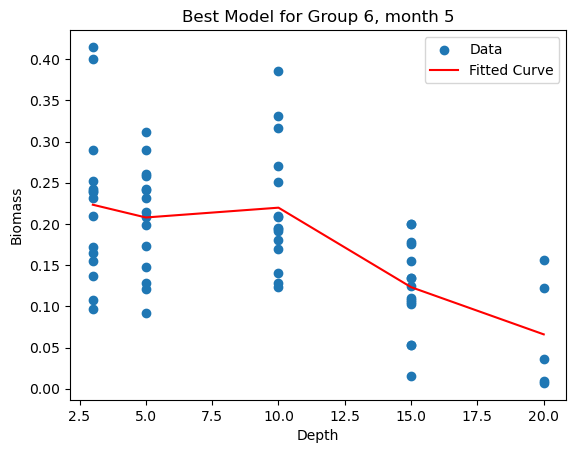

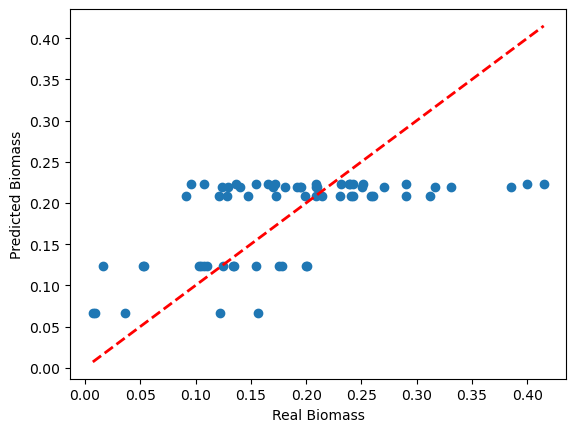

Group: 6
Month: 6
Best Model: quartic
Best Model Parameters: [ 9.28668454e-06 -5.36987100e-04  1.02377863e-02 -8.16457340e-02
  3.64729418e-01]

R-Squared: 0.3906868852490093


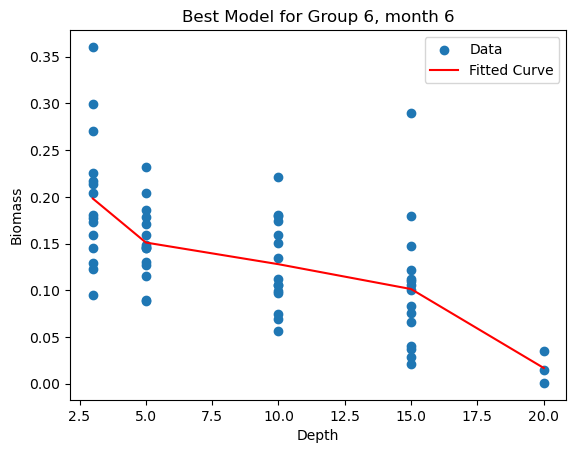

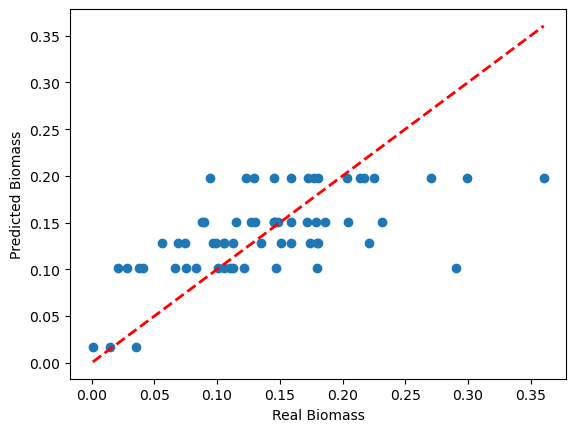

Group: 6
Month: 7
Best Model: quartic
Best Model Parameters: [-7.67957172e-06  3.37690443e-04 -5.28082635e-03  2.78456165e-02
  1.31402950e-01]

R-Squared: 0.3188057119839812


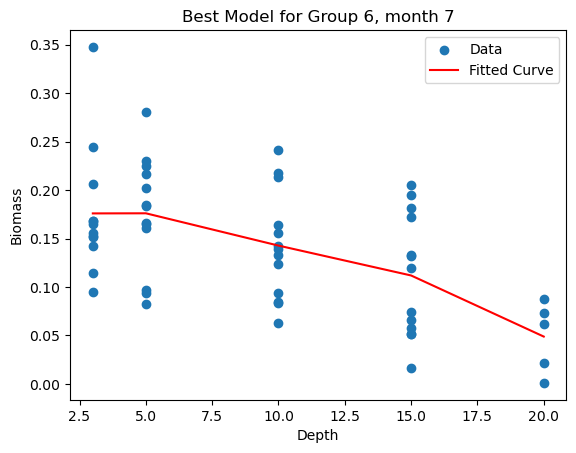

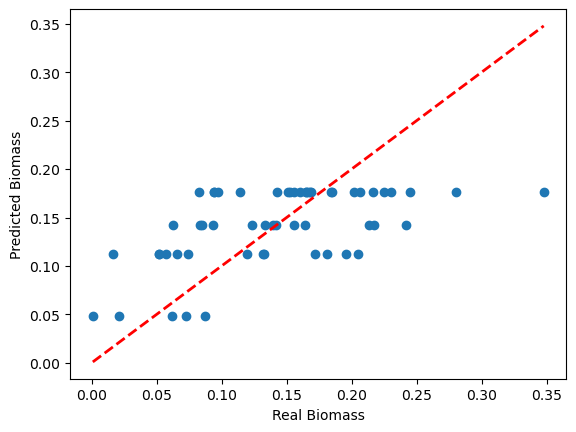

Group: 6
Month: 8
Best Model: quartic
Best Model Parameters: [-2.86077114e-06  1.57793407e-04 -3.72649122e-03  3.52640214e-02
  6.16141577e-02]

R-Squared: 0.08791171642935935


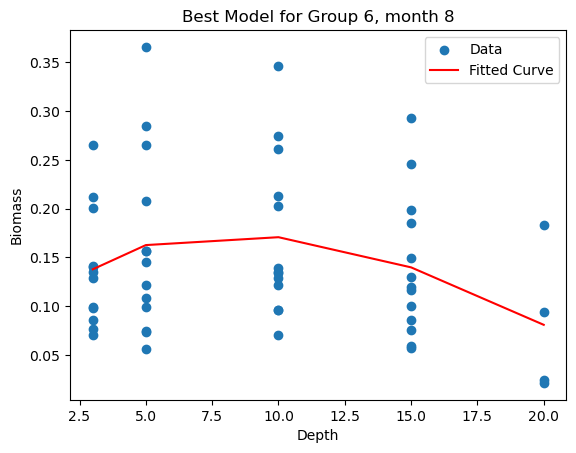

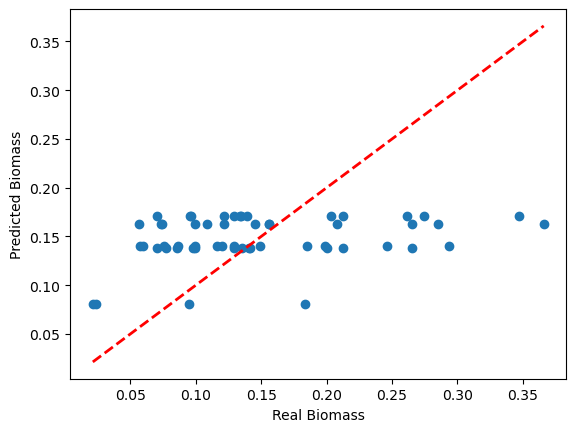

Group: 6
Month: 9
Best Model: quartic
Best Model Parameters: [ 1.57511804e-05 -7.66872035e-04  1.20661399e-02 -7.23383965e-02
  2.87408355e-01]

R-Squared: 0.23804736748002076


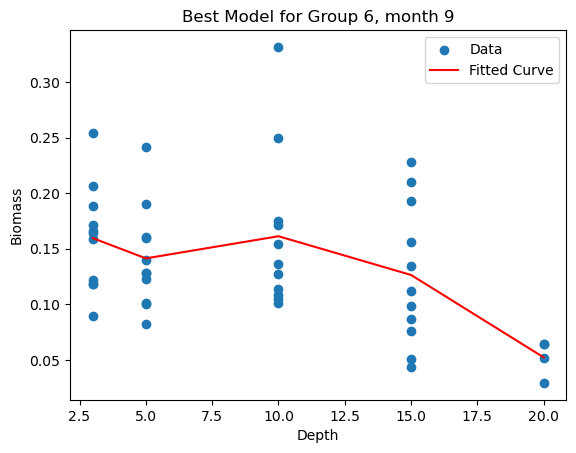

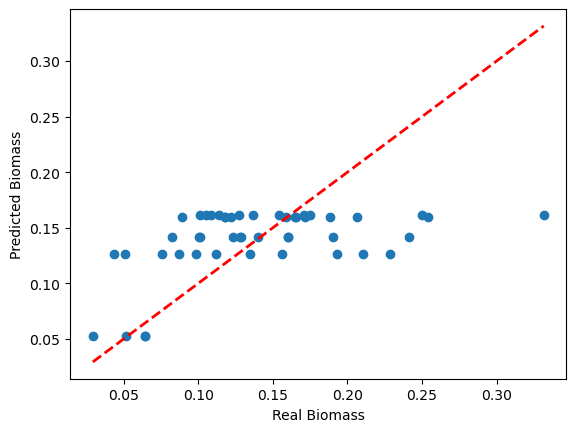

Group: 6
Month: 10
Best Model: quartic
Best Model Parameters: [-1.49809936e-05  6.88360947e-04 -1.14342751e-02  7.41667293e-02
  1.68395221e-02]

R-Squared: 0.3039536615504851


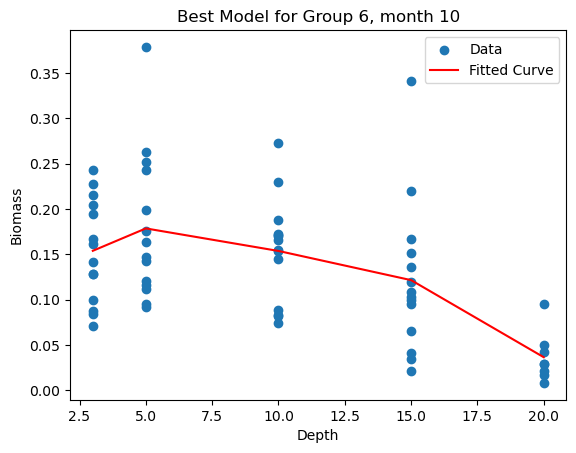

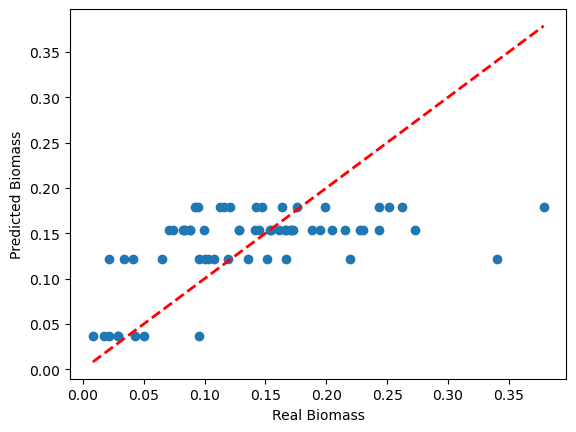

Group: 6
Month: 11
Best Model: quartic
Best Model Parameters: [-4.80002153e-06  1.82787991e-04 -2.37585830e-03  9.69977405e-03
  1.69232404e-01]

R-Squared: 0.18236243655379047


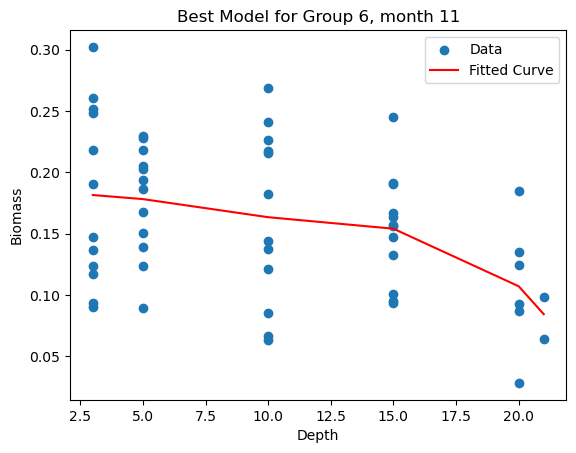

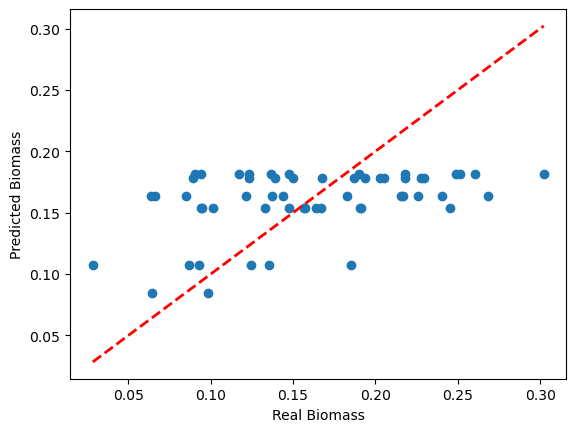

Group: 6
Month: 12
Best Model: quartic
Best Model Parameters: [ 1.44860896e-07 -5.13845715e-05  1.74706900e-03 -1.70834962e-02
  2.32393265e-01]

R-Squared: 0.14306165762532697


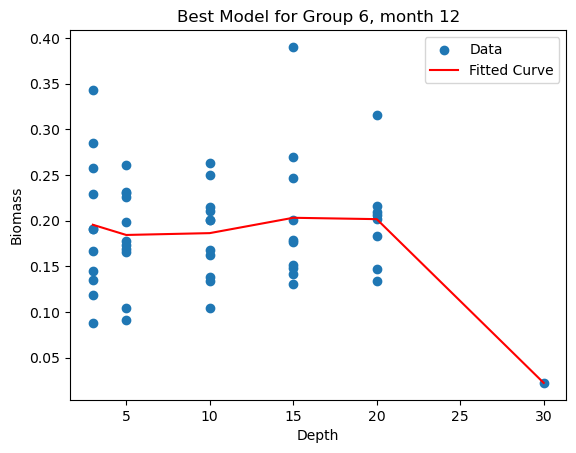

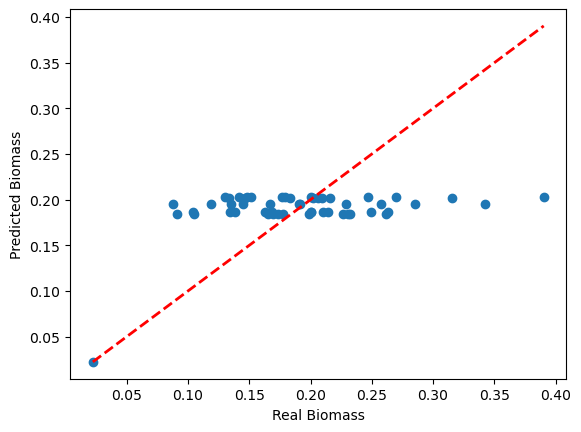

In [8]:
# Loop through the best models for each group and month and print/visualize
for group, month_models in best_models_per_group_month.items():
    for month, (best_model_name, best_model_params) in month_models.items():
        print("Group:", group)
        print("Month:", month)
        print("Best Model:", best_model_name)
        print("Best Model Parameters:", best_model_params)
        print()

        best_model_func = next(model_func for model_func in models if model_func[0] == best_model_name)[1]
        group_month_data = biomass_by_week_year_group[(biomass_by_week_year_group['group_num'] == group) & (biomass_by_week_year_group['month'] == month)]
        group_month_data = group_month_data.sort_values('Depth')
        depths = group_month_data['Depth']
        predicted_biomass = best_model_func(depths, *best_model_params)
        r_squared = r2_score(group_month_data['sum_biomass_ug_ml'], predicted_biomass)
        print("R-Squared:", r_squared)

        plt.scatter(depths, group_month_data['sum_biomass_ug_ml'], label="Data")
        plt.plot(depths, predicted_biomass, color='red', label="Fitted Curve")
        plt.xlabel("Depth")
        plt.ylabel("Biomass")
        plt.title(f"Best Model for Group {group}, month {month}")
        plt.legend()
        plt.show()
        
        plt.scatter(group_month_data['sum_biomass_ug_ml'], predicted_biomass)
        plt.plot([group_month_data['sum_biomass_ug_ml'].min(), group_month_data['sum_biomass_ug_ml'].max()], [group_month_data['sum_biomass_ug_ml'].min(), group_month_data['sum_biomass_ug_ml'].max()], 'r--', lw=2)  # Add a diagonal line for reference
        plt.xlabel("Real Biomass")
        plt.ylabel("Predicted Biomass")
        plt.show()

In [9]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

In [11]:
merged_df = merge_fp_biomass_df(fp_df, biomass_by_week_year_group)

In [ ]:
# Calculate estimated sum_biomass_ug_ml
estimated_biomass = []
current_step = 0  # Initialize the step for the current week-year-month frame
depth_diffs = []

for index, row in merged_df.iterrows():
    # Calculate step for the current week-year-month frame
    model = best_models_per_group_month[row.group_num][row.month]
    if next_df.shape[0] > 0:
        step_numenrator = row['sum_biomass_ug_ml'] - next_df.iloc[0]['sum_biomass_ug_ml']
        step_denominator = row['Depth'] - next_df.iloc[0]['Depth']
    else:
        step_numenrator = row['sum_biomass_ug_ml']
        step_denominator = row['Depth']

    current_step = step_numerator / step_denominator
        
    depth_diff = row['Depth'] - row['depth']
    depth_diffs.append(depth_diff)
    
    estimated_biomass_value = row['sum_biomass_ug_ml']
    estimated_biomass_value += current_step * depth_diff
    
    estimated_biomass.append(estimated_biomass_value)

merged_df['estimated_sum_biomass_ug_ml'] = estimated_biomass
merged_df['depth_diffs'] = depth_diffs
merged_df